In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy

from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

#numpix = 220 # 60/resolution (for an 1 arcmin wide image)
numpix = 113

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Color distribution
colors = pd.read_csv('color_distribution/source_colors.csv')
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.1 # Range of redshift for filtering
dm = 0.2 # Range of magnitude for filtering

def color_distribution(z, m):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [4]:
def funcion(z_lens, z_source1, z_source2, sigma ,center_lens, center_source1, center_source2, lens_ellip, i):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [z_lens],  # list of redshift of the deflections
                          #'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [z_source1, z_source2],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source': z_source2} # redshift of the default source (if not further specified by 'source_redshift_list') 
                           #and also serves as the redshift of lensed point sources}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)#, kwargs_numerics=kwargs_numerics)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': center_lens[0], 'center_y': center_lens[1], 'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)

    #colors of the other bands for each source
    g_r_source_1, r_i_source_1 = color_distribution(z_source1, 22)
    g_r_source_2, r_i_source_2 = color_distribution(z_source2, 23)
    
    #sources light:
    kwargs_source_mag_g_1 = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': center_source1[0], 'center_y': center_source1[1]}]
    kwargs_source_mag_g_2 = [{'magnitude': 23, 'R_sersic': 0.3, 'n_sersic': 1.5, 'center_x': center_source2[0], 'center_y': center_source2[1]}]
    
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_1[0]['magnitude'] -= g_r_source_1
    
    kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
    kwargs_source_mag_r_2[0]['magnitude'] -= g_r_source_2
    
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_r_1)
    kwargs_source_mag_i_1[0]['magnitude'] -= r_i_source_1
    
    kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_r_2)
    kwargs_source_mag_i_2[0]['magnitude'] -= r_i_source_2
    
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig('Image' + str(i) + '.png')
    #plt.show(block=True)

In [5]:
#data
data = pd.read_csv('Data/redmagic_sdss_allcolumns.csv')
data

,COADD_OBJECT_ID,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,ID
0,188536135,317.999774,-2.047044,0.156339,0.079792,0.459138,272.88403,188536135
1,210952287,326.339041,-0.003665,0.173799,0.082191,0.447773,251.80692,210952287
2,210938821,326.570650,0.209584,0.236705,-0.187670,0.627276,304.14548,210938821
3,212176275,325.924446,-0.765189,0.110214,0.074650,0.549774,228.24649,212176275
4,307585462,38.238711,-6.155106,-0.007181,-0.041391,0.300392,265.68323,307585462
...,...,...,...,...,...,...,...,...
20260,195612913,319.310673,0.543804,-0.046734,0.242707,0.429028,244.55160,195612913
20261,240141913,328.970001,2.105566,-0.474940,0.045203,0.482786,239.46298,240141913
20262,244799359,329.283980,1.654080,-0.088592,-0.038036,0.238356,267.64230,244799359
20263,181031970,317.931260,1.471896,-0.094317,0.018450,0.444647,242.59583,181031970


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


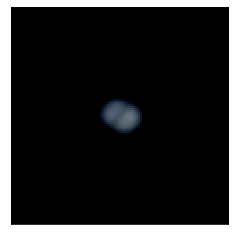

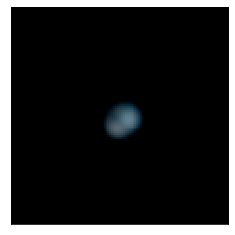

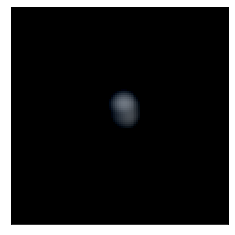

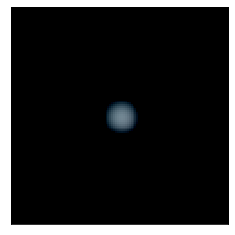

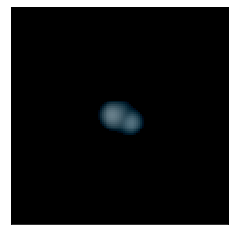

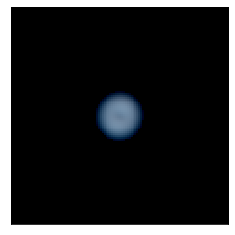

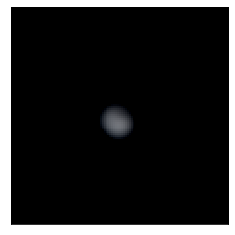

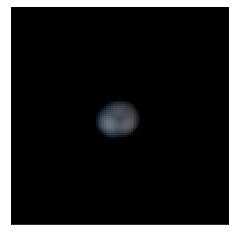

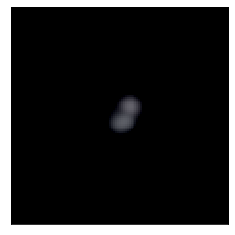

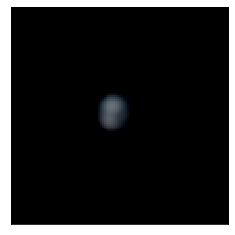

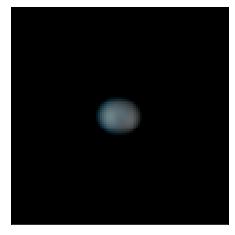

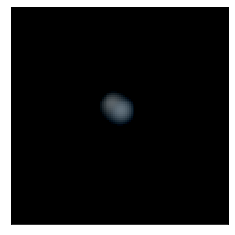

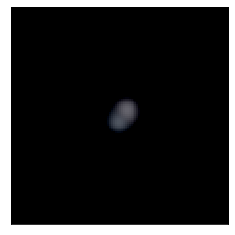

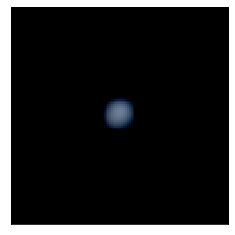

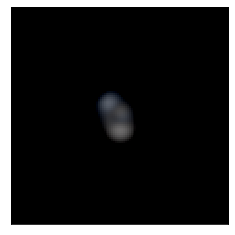

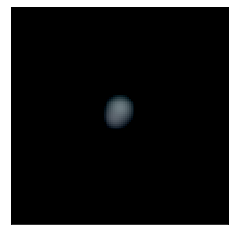

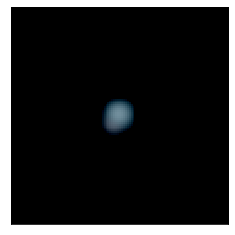

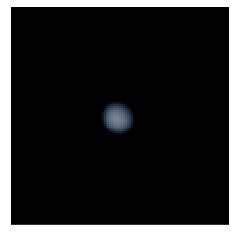

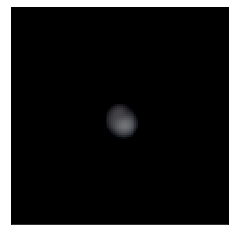

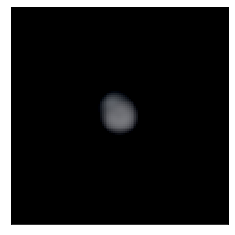

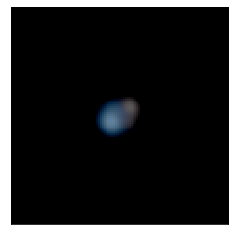

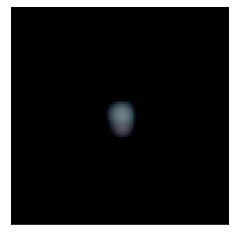

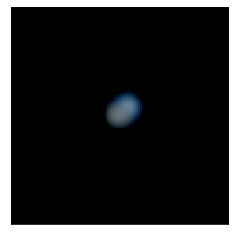

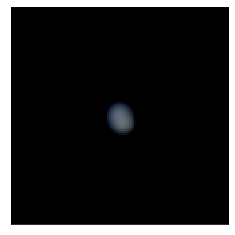

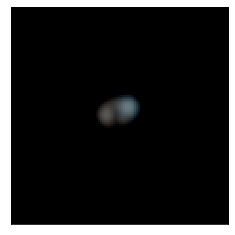

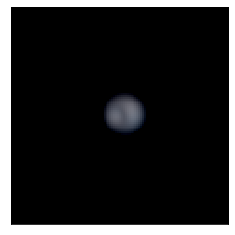

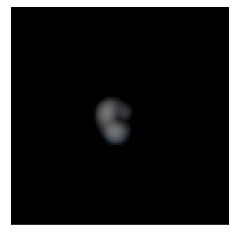

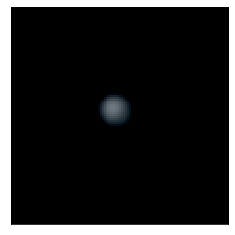

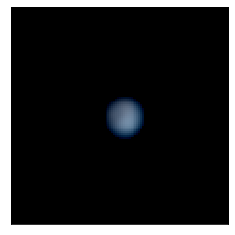

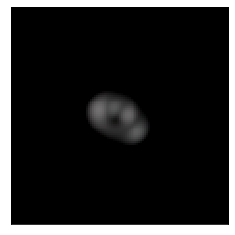

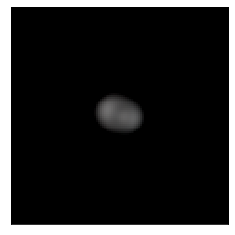

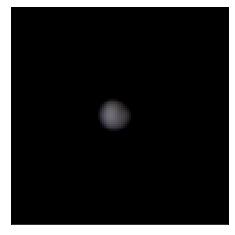

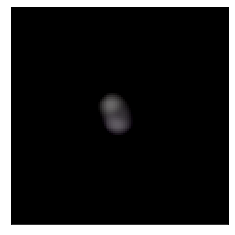

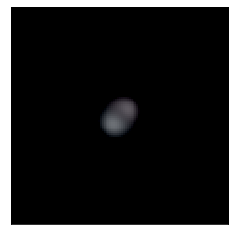

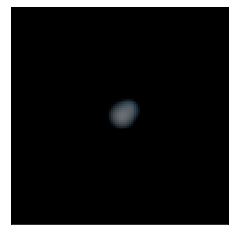

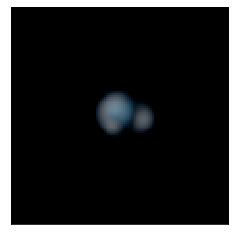

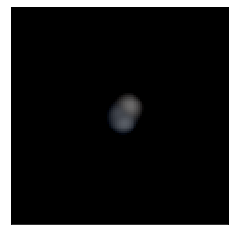

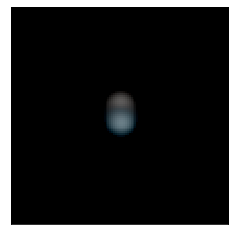

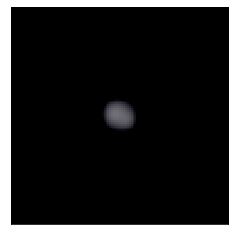

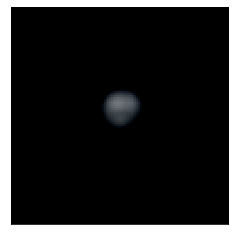

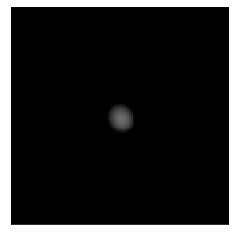

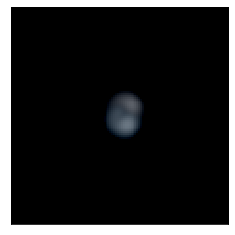

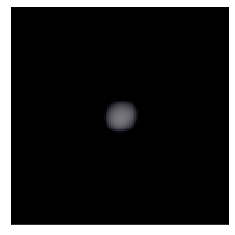

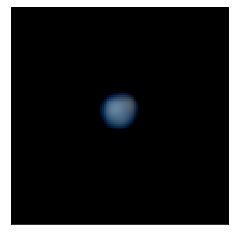

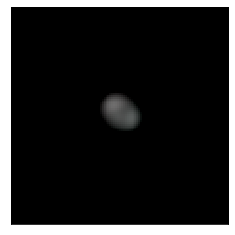

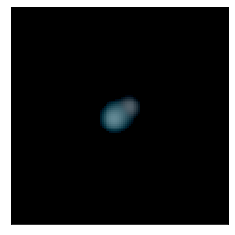

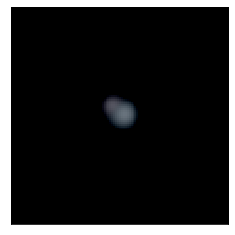

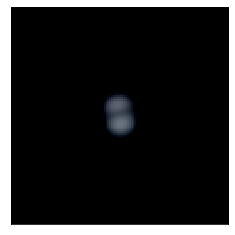

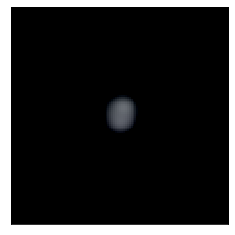

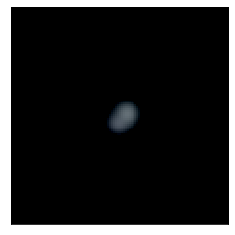

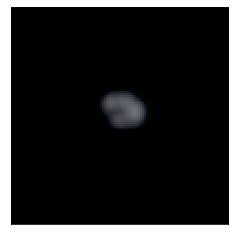

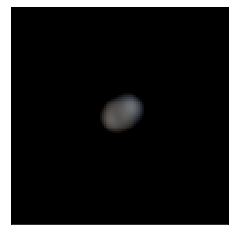

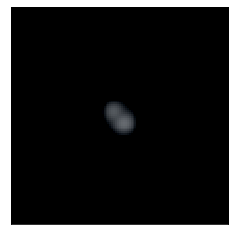

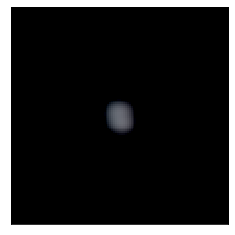

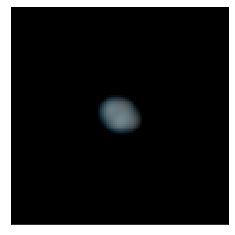

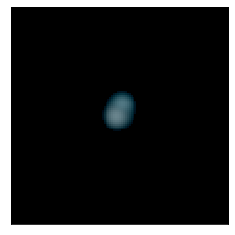

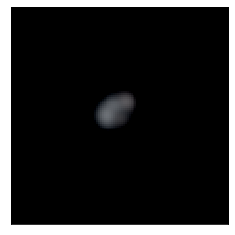

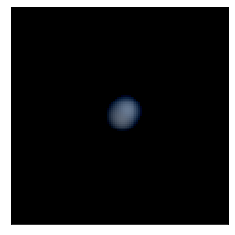

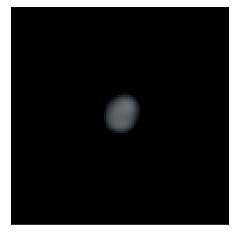

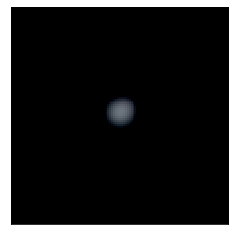

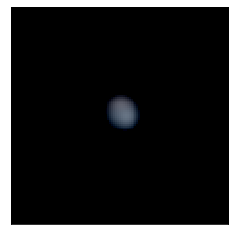

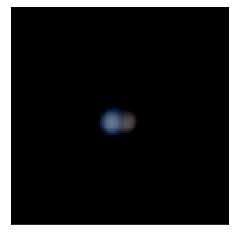

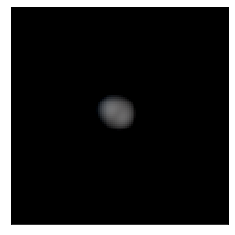

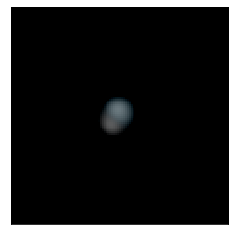

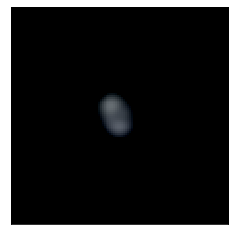

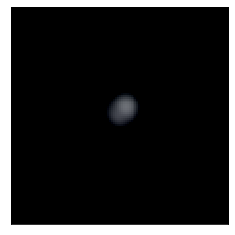

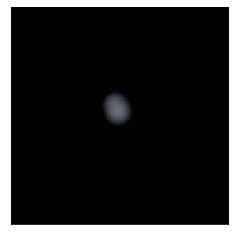

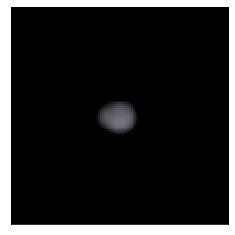

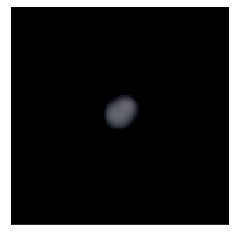

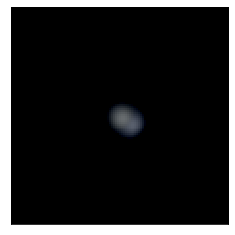

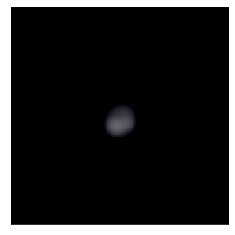

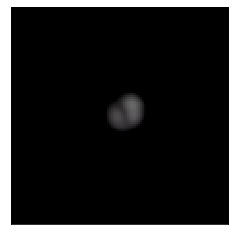

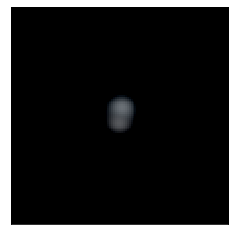

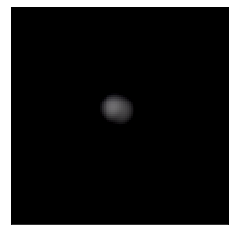

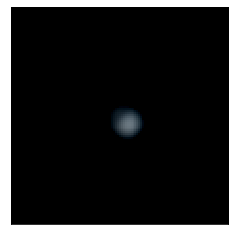

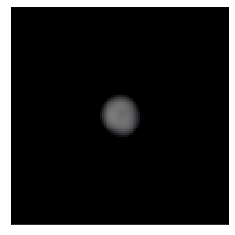

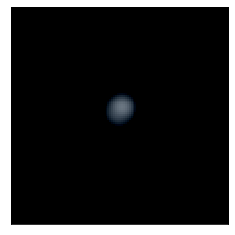

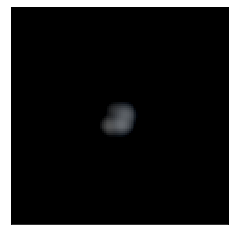

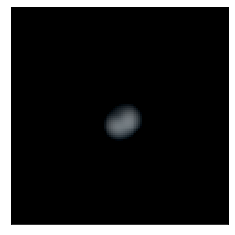

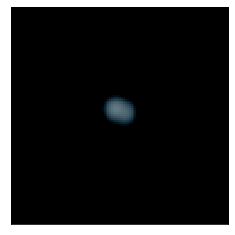

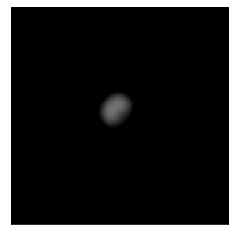

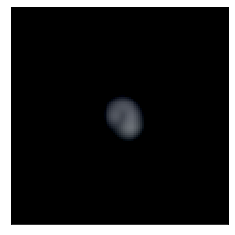

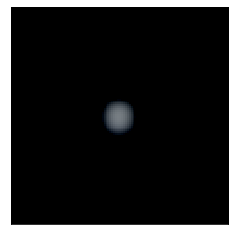

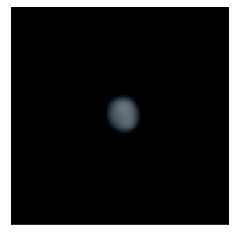

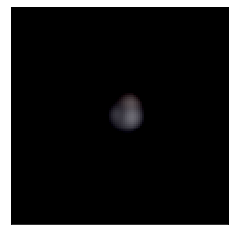

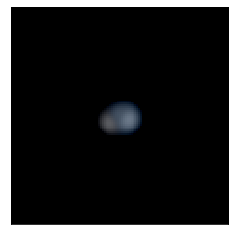

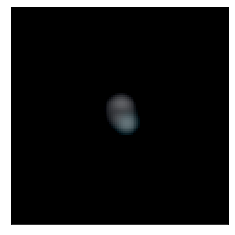

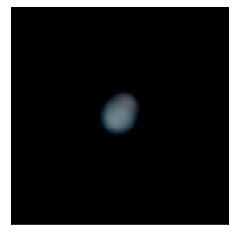

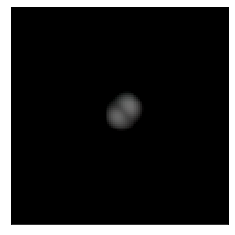

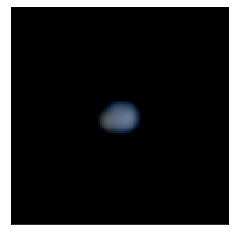

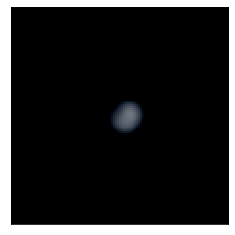

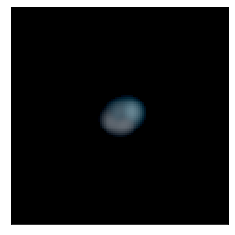

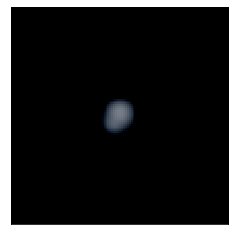

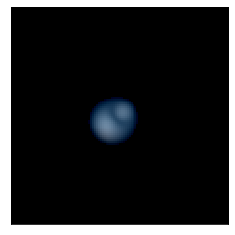

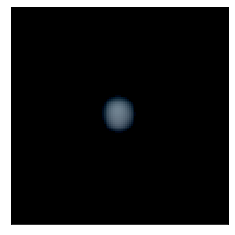

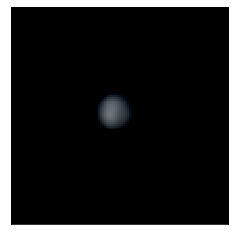

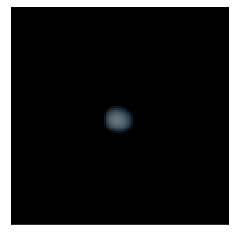

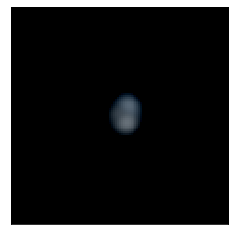

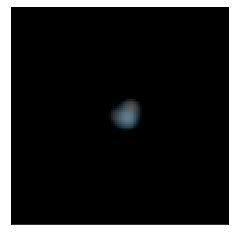

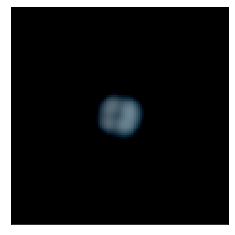

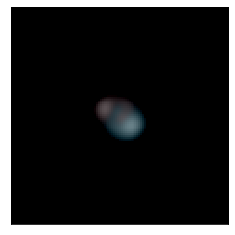

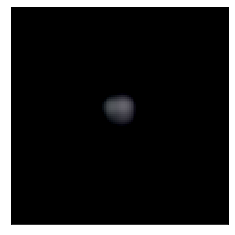

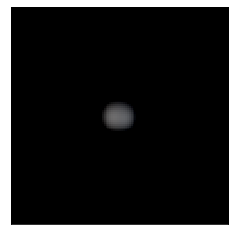

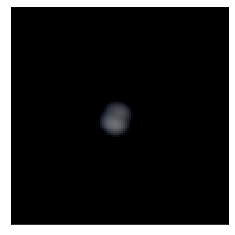

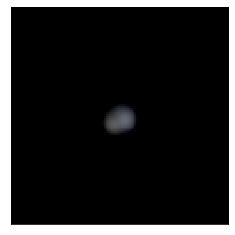

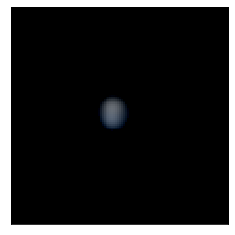

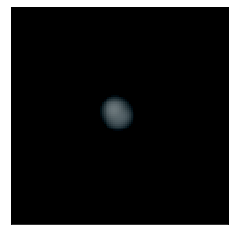

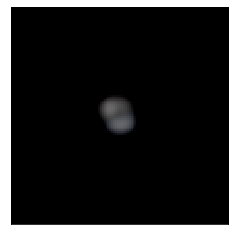

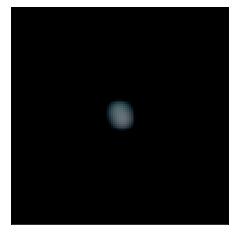

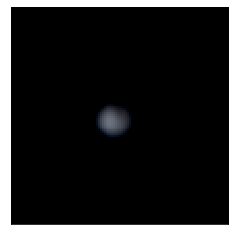

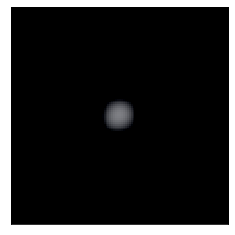

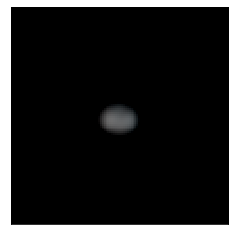

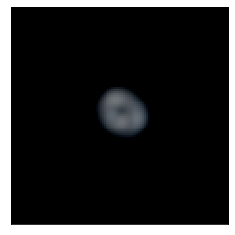

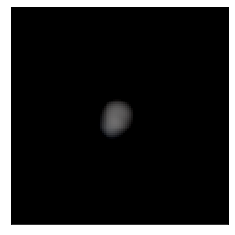

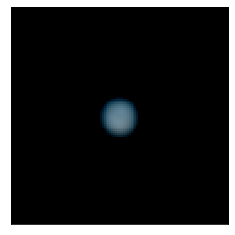

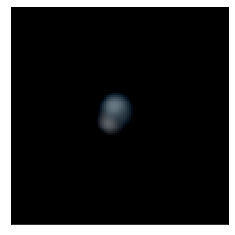

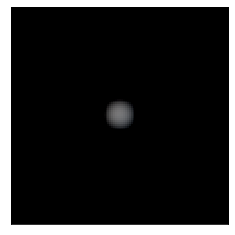

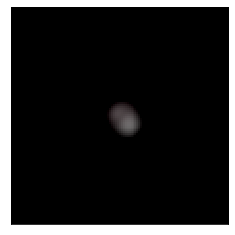

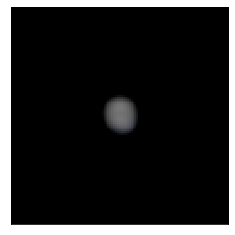

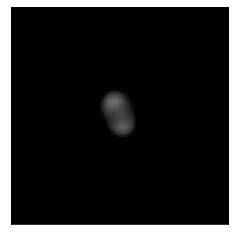

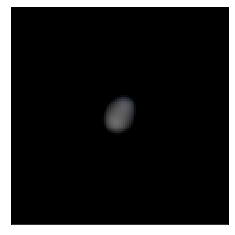

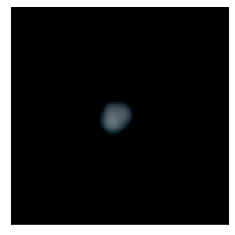

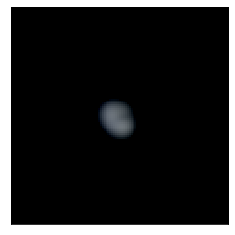

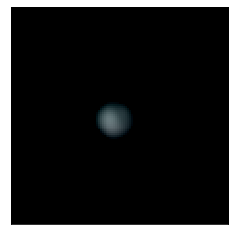

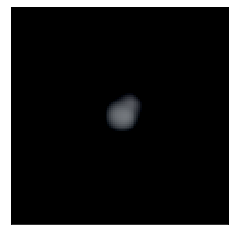

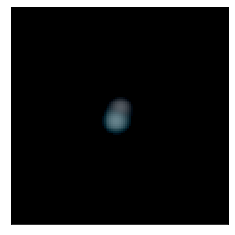

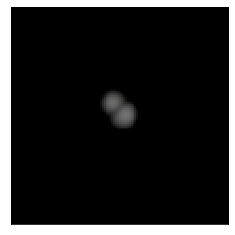

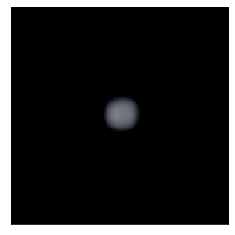

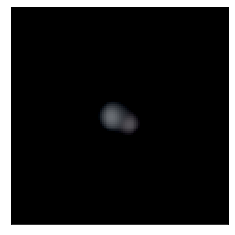

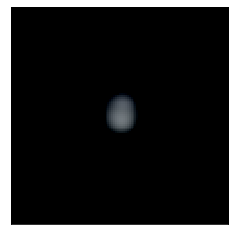

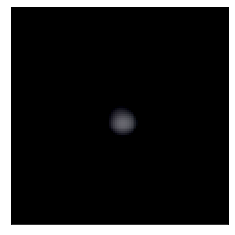

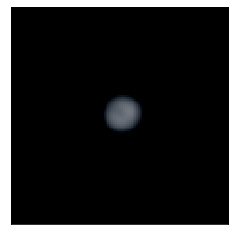

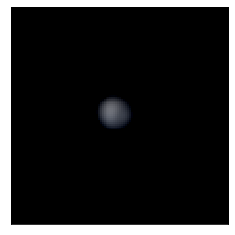

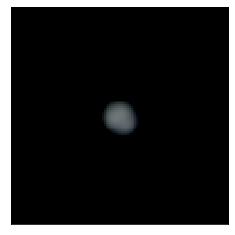

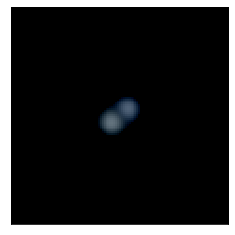

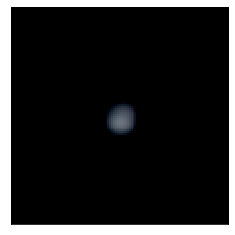

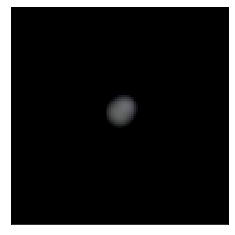

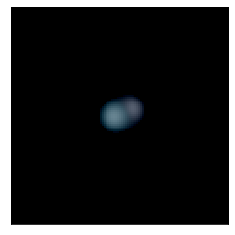

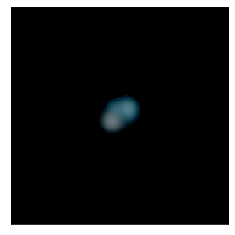

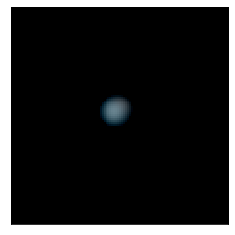

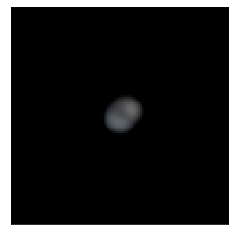

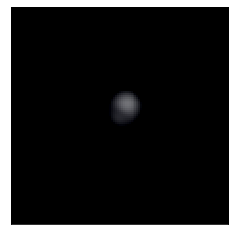

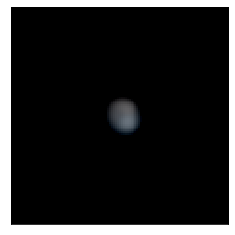

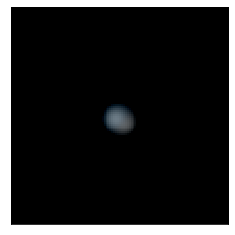

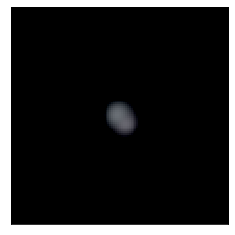

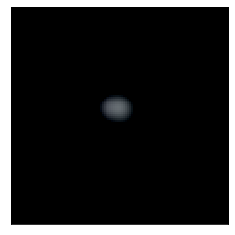

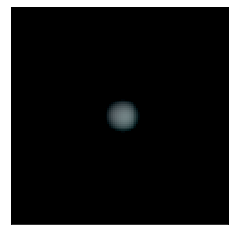

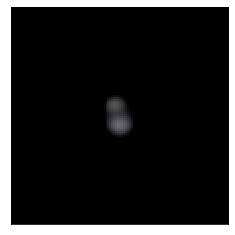

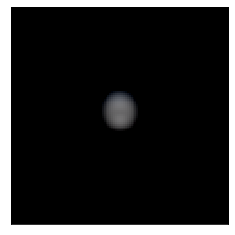

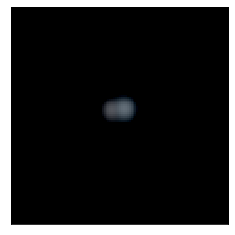

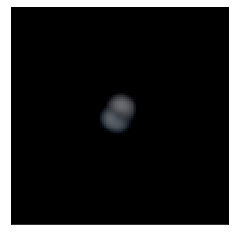

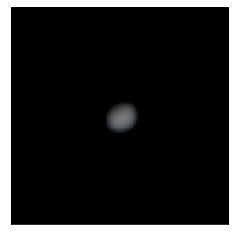

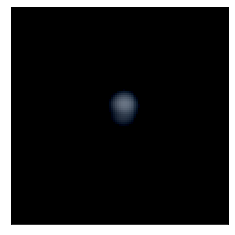

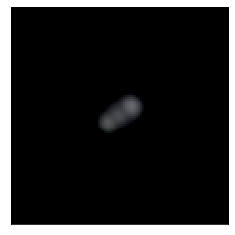

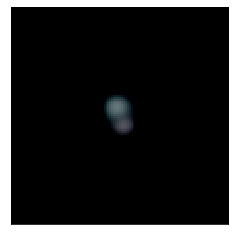

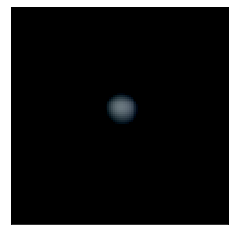

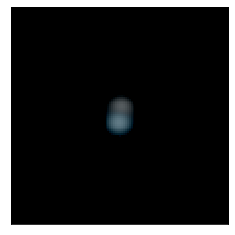

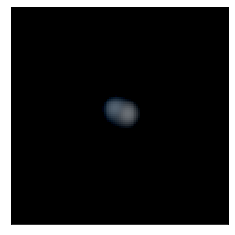

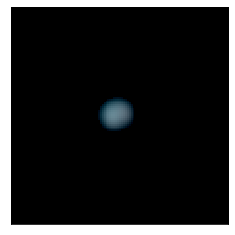

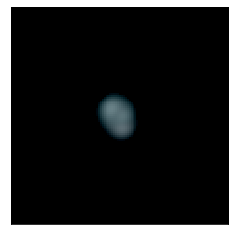

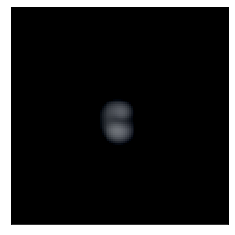

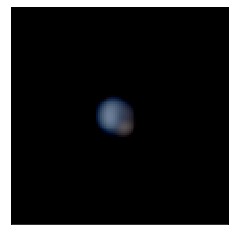

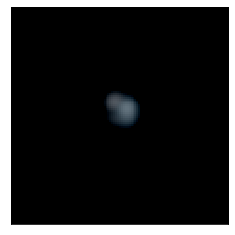

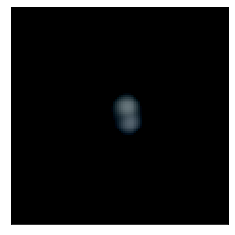

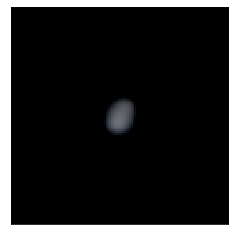

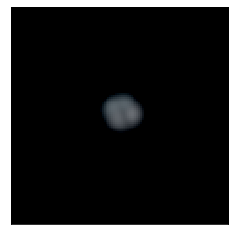

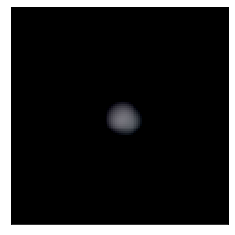

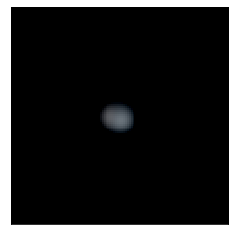

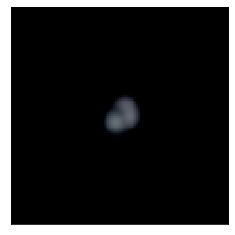

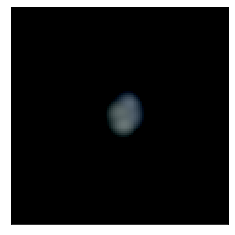

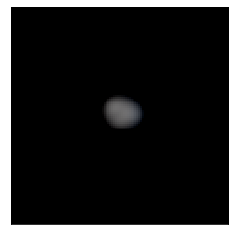

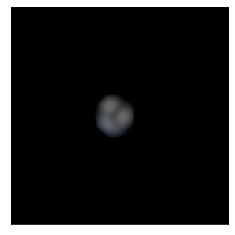

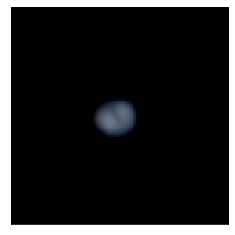

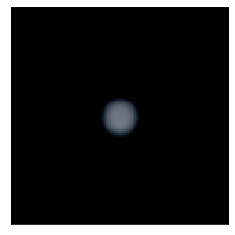

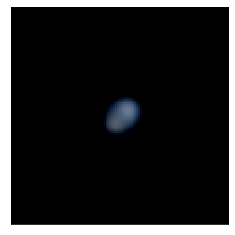

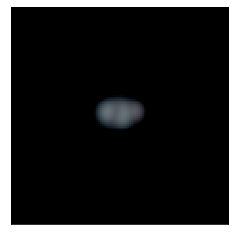

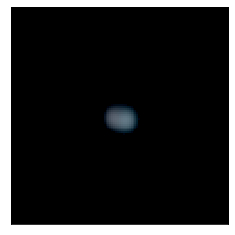

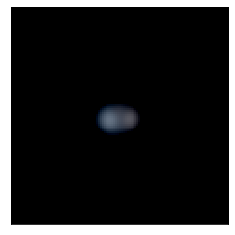

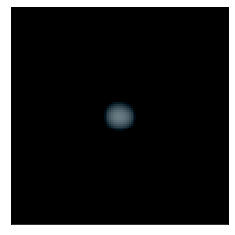

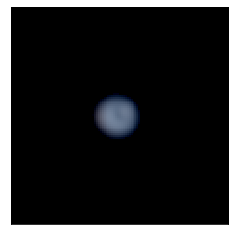

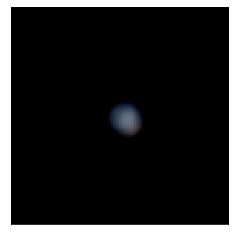

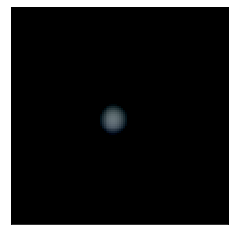

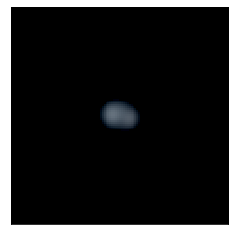

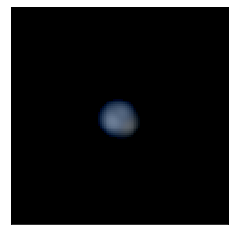

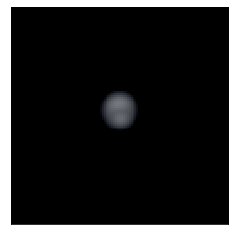

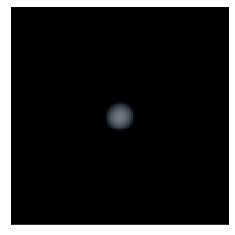

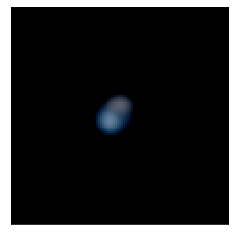

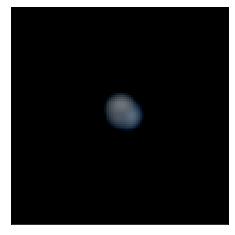

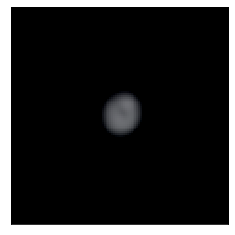

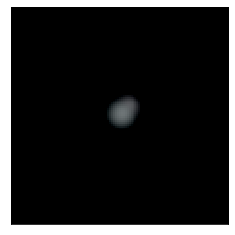

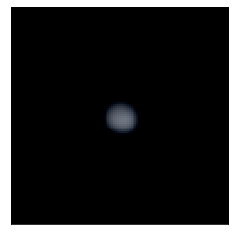

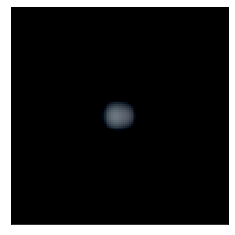

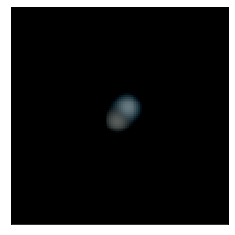

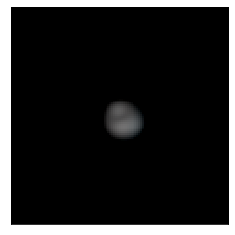

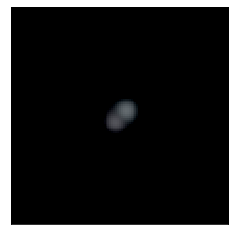

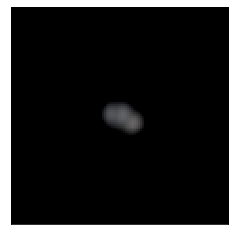

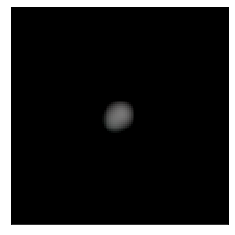

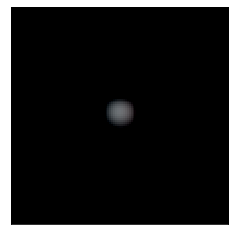

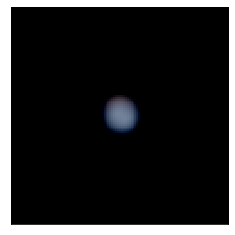

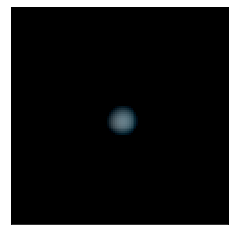

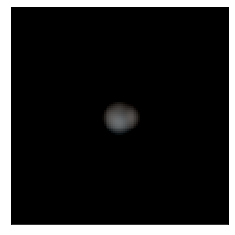

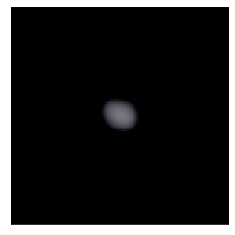

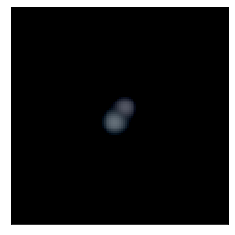

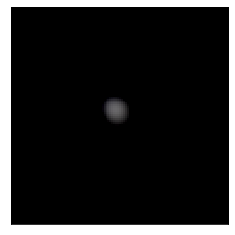

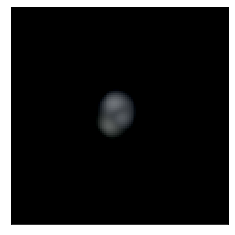

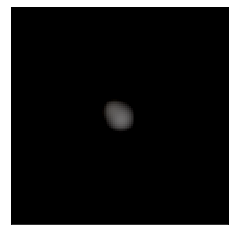

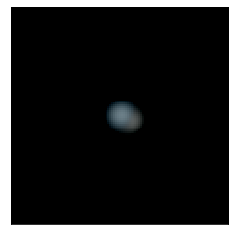

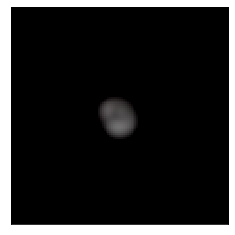

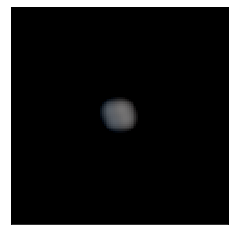

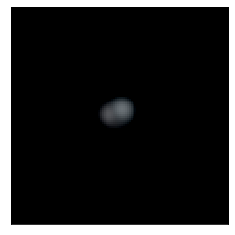

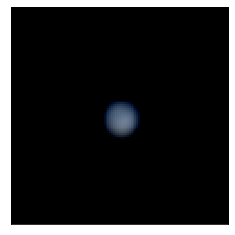

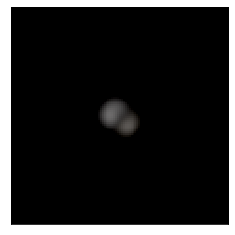

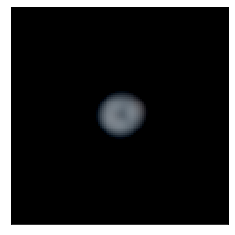

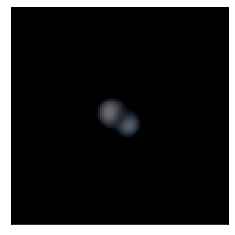

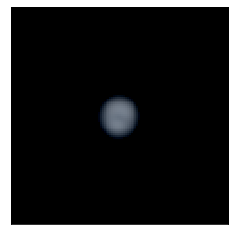

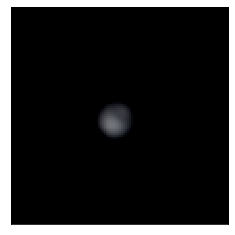

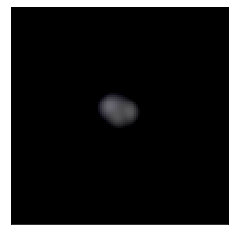

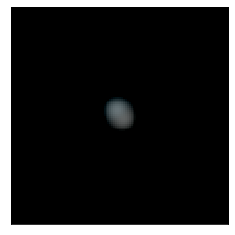

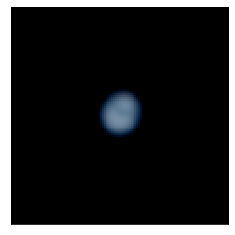

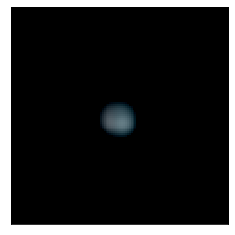

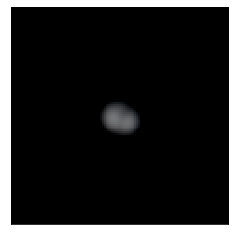

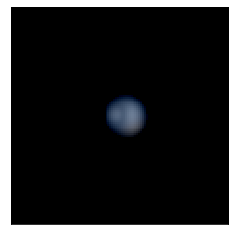

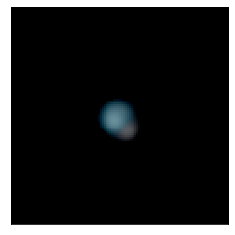

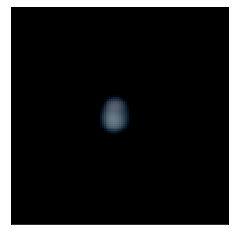

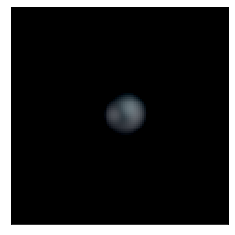

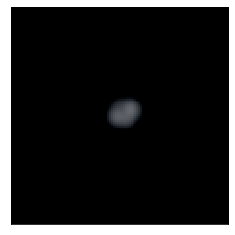

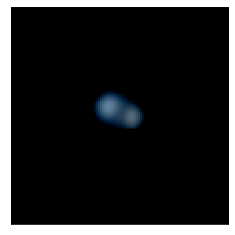

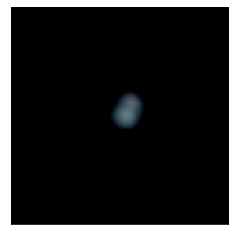

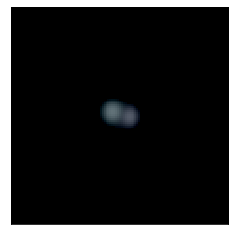

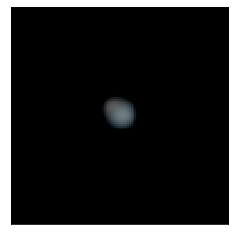

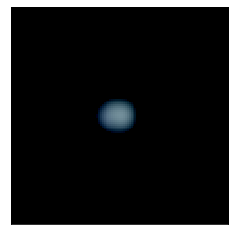

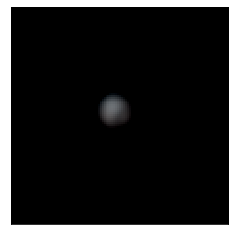

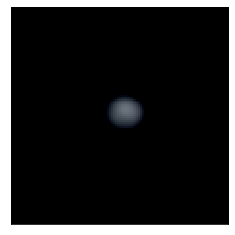

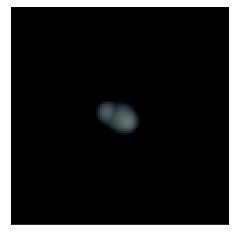

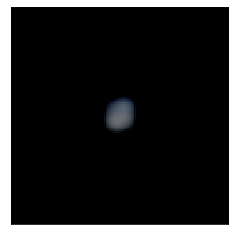

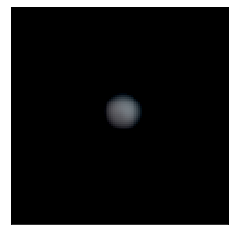

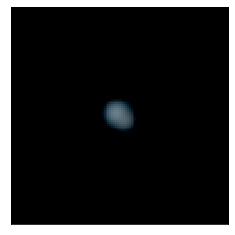

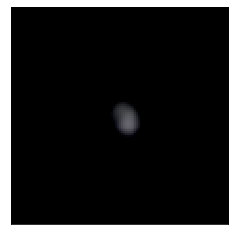

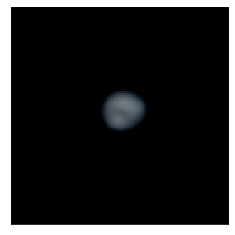

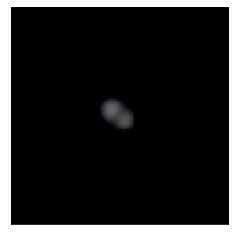

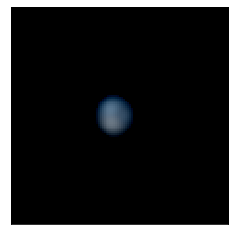

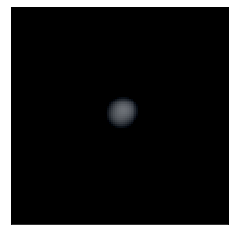

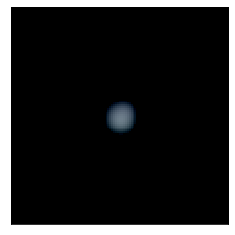

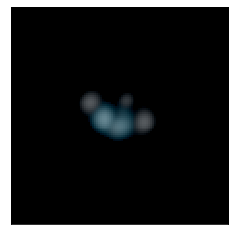

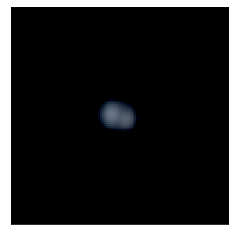

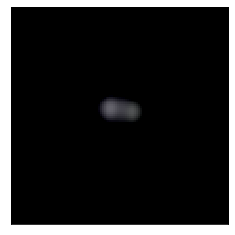

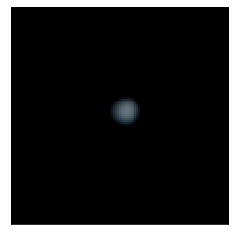

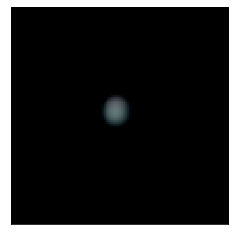

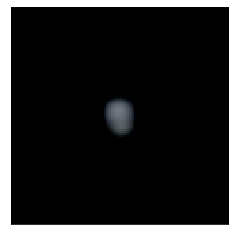

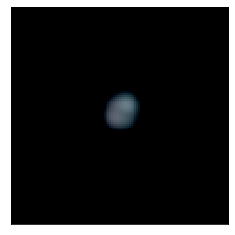

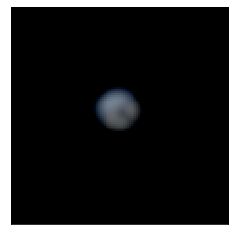

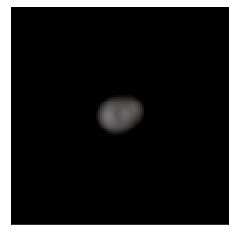

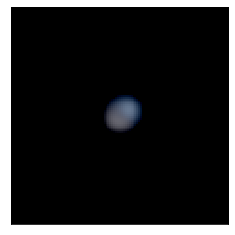

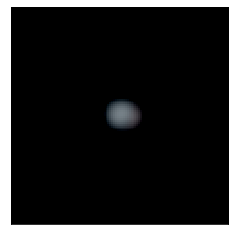

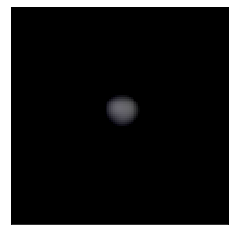

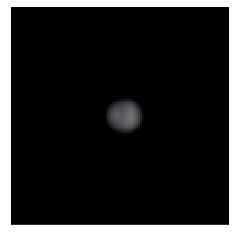

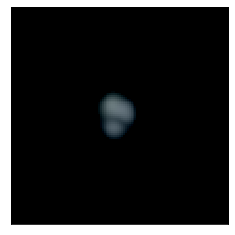

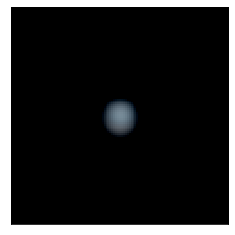

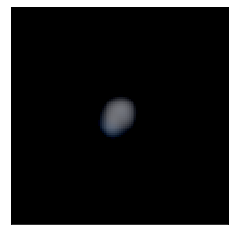

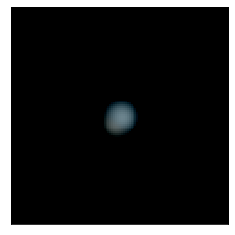

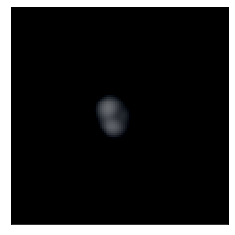

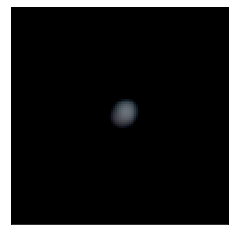

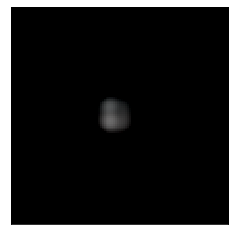

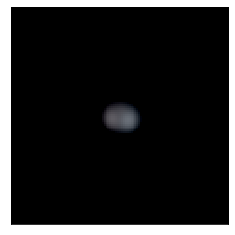

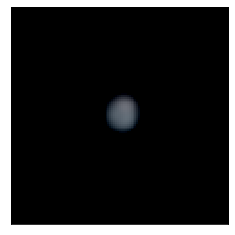

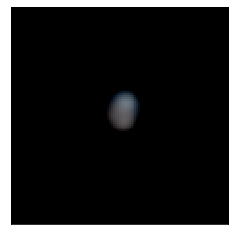

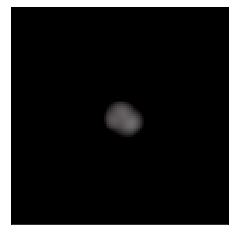

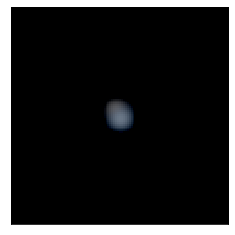

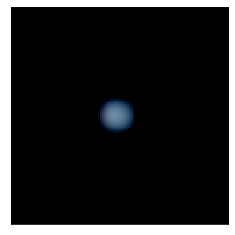

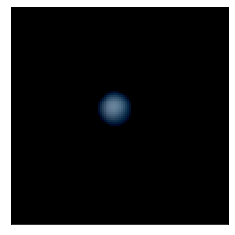

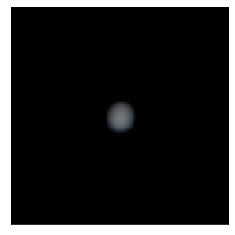

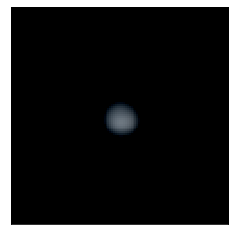

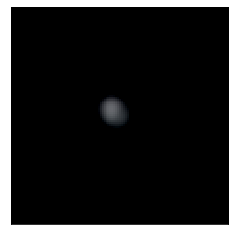

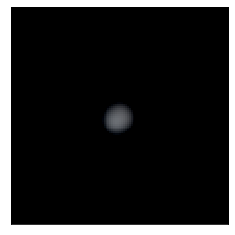

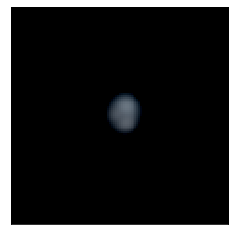

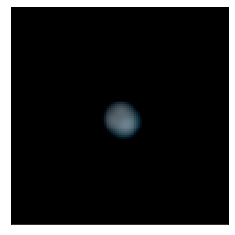

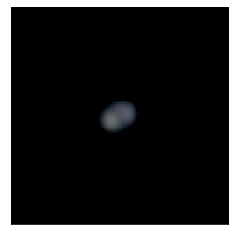

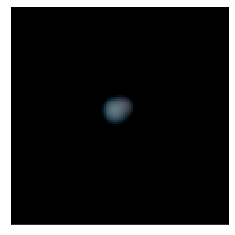

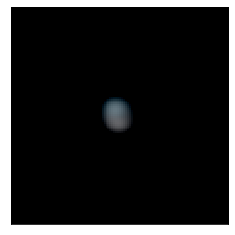

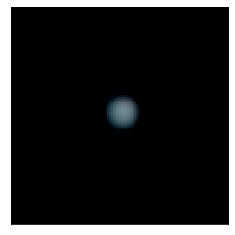

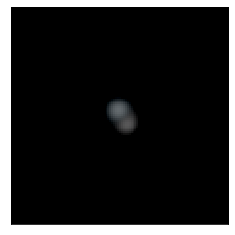

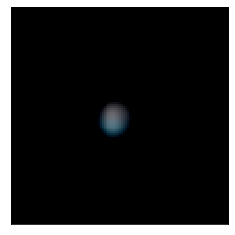

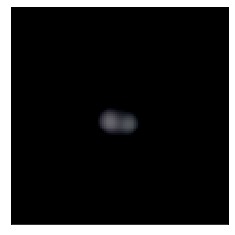

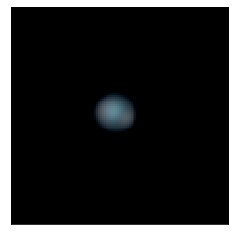

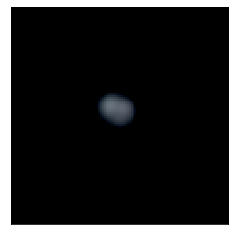

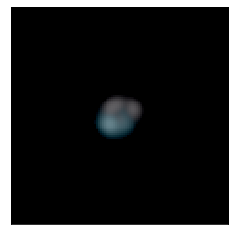

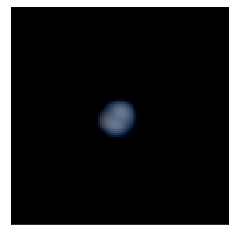

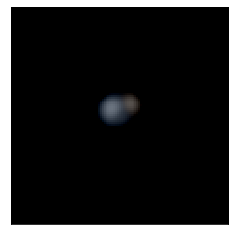

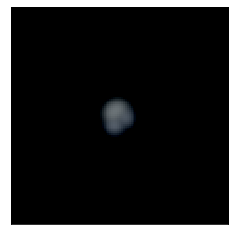

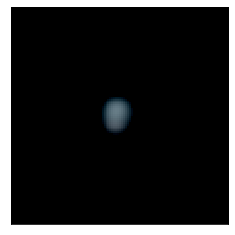

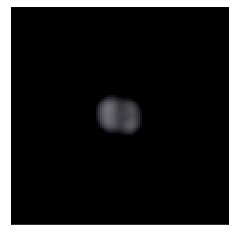

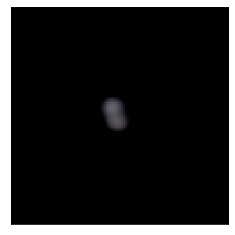

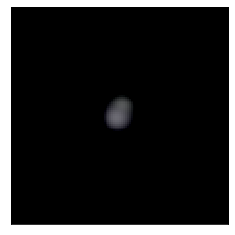

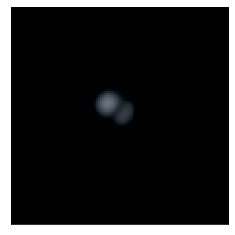

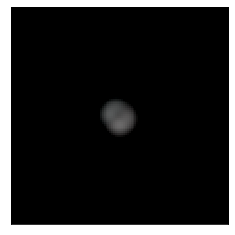

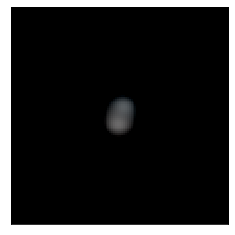

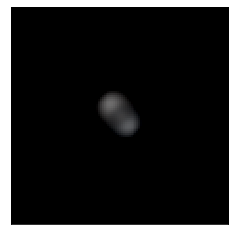

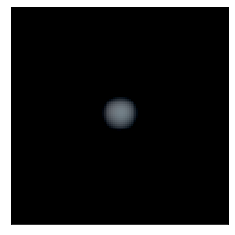

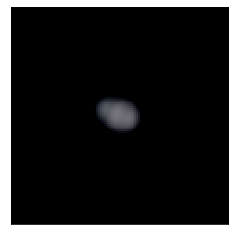

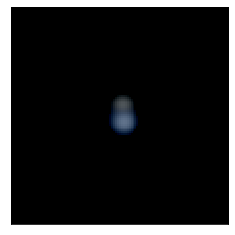

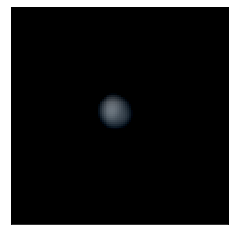

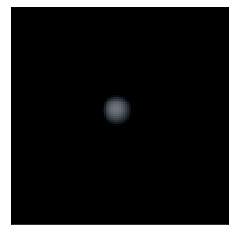

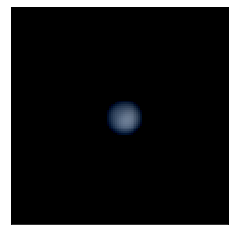

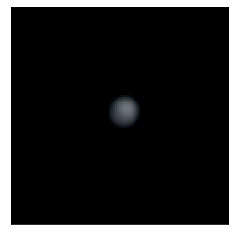

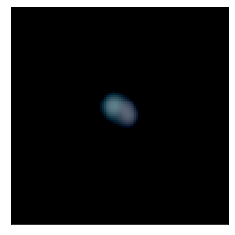

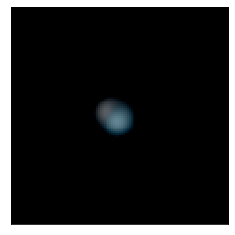

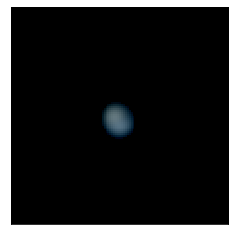

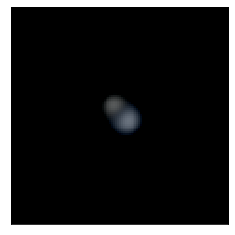

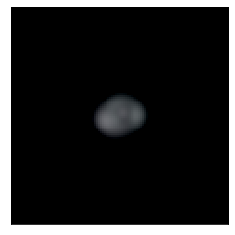

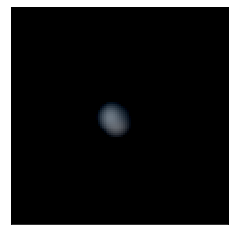

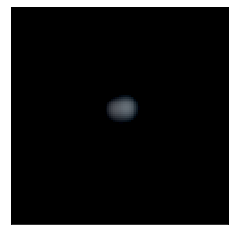

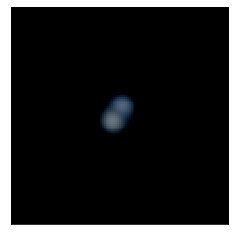

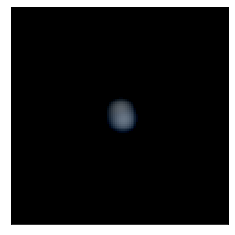

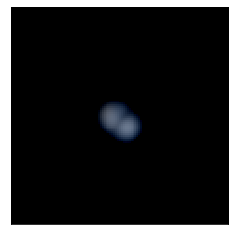

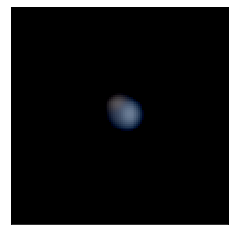

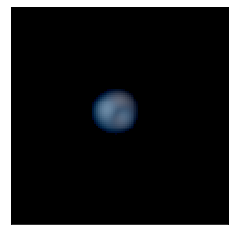

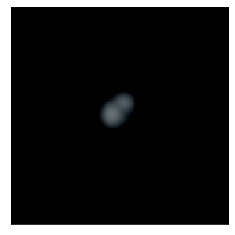

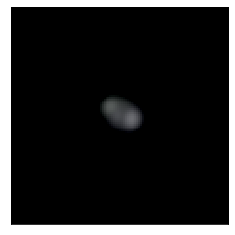

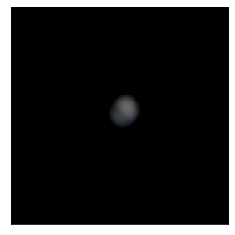

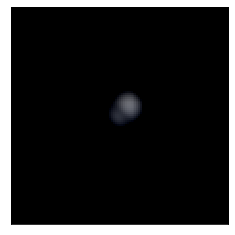

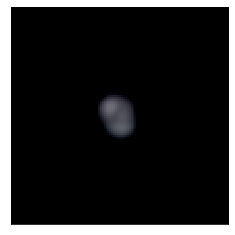

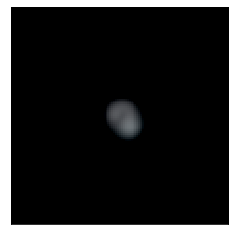

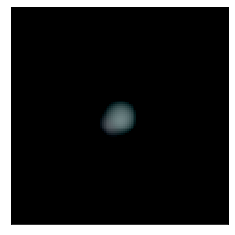

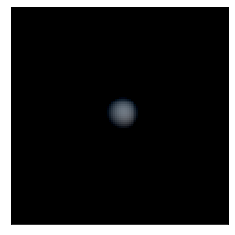

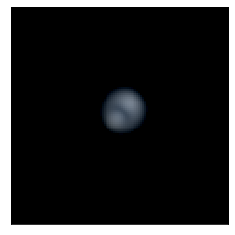

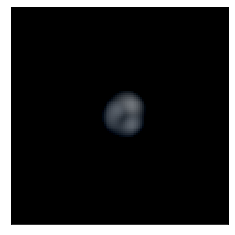

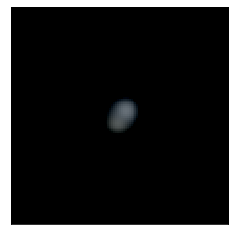

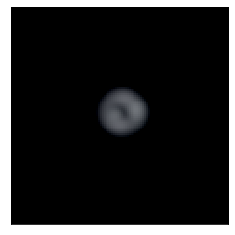

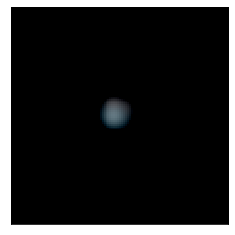

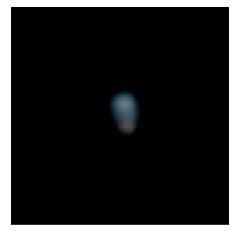

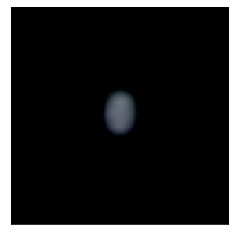

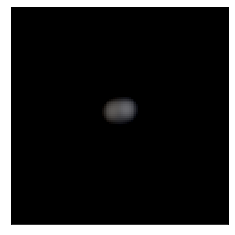

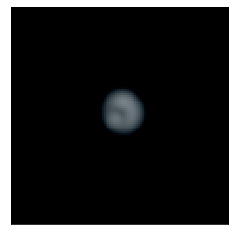

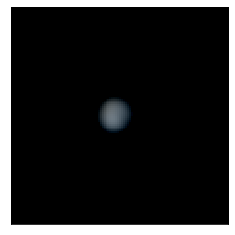

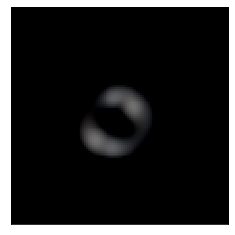

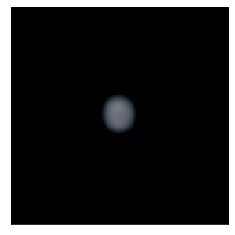

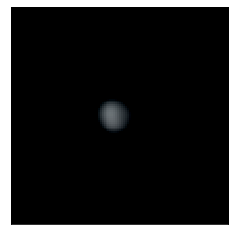

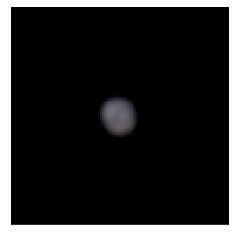

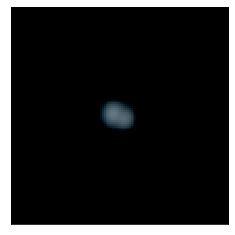

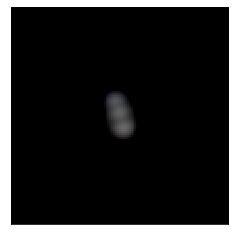

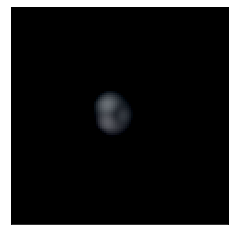

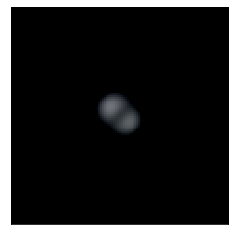

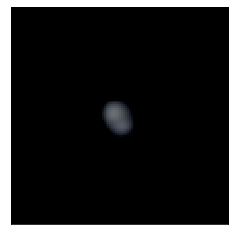

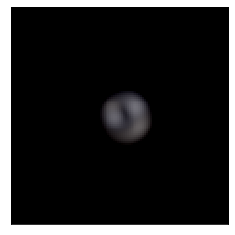

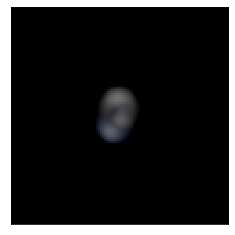

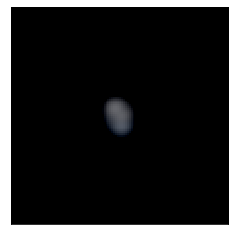

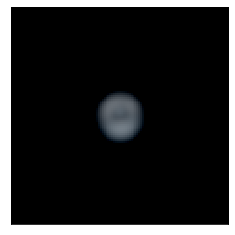

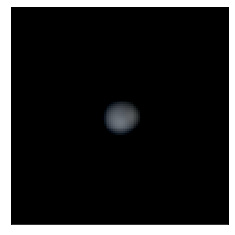

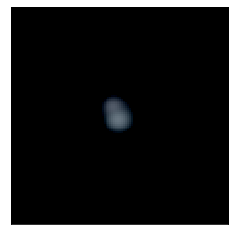

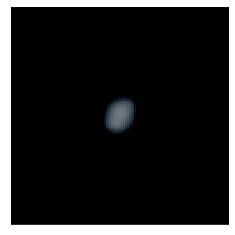

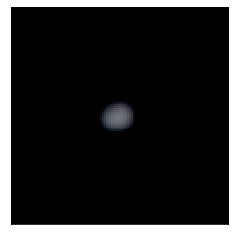

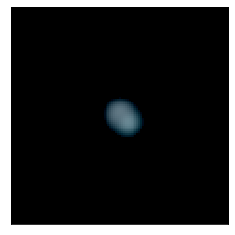

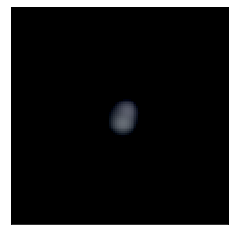

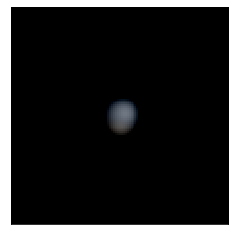

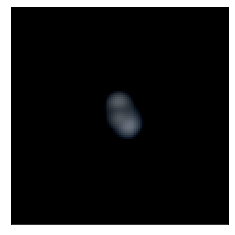

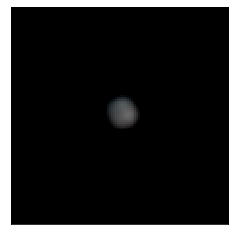

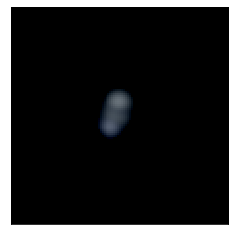

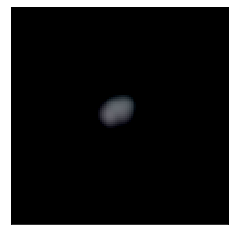

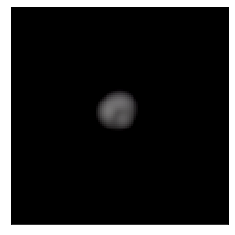

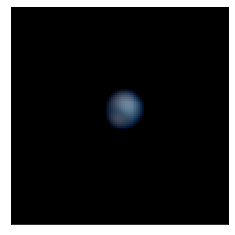

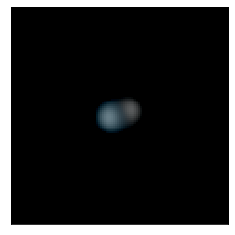

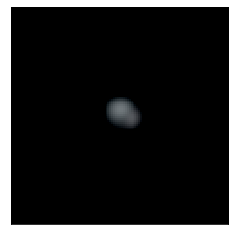

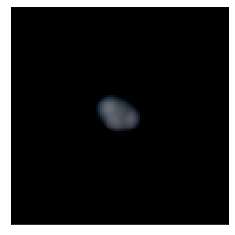

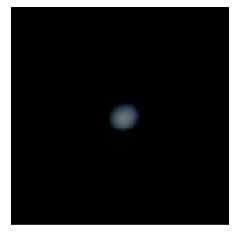

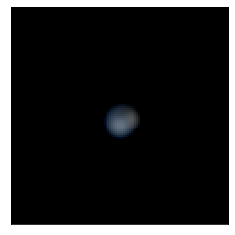

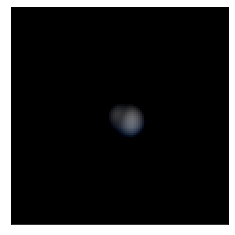

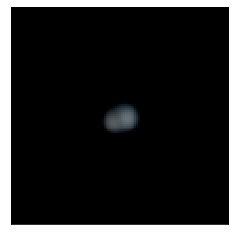

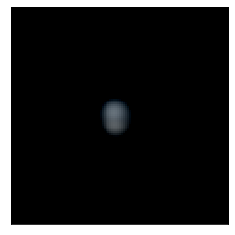

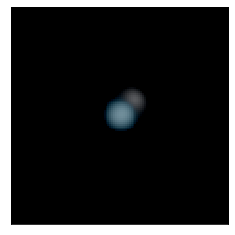

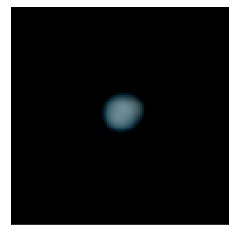

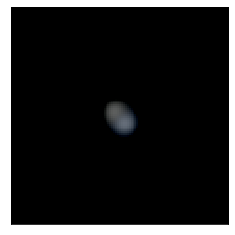

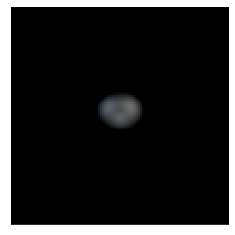

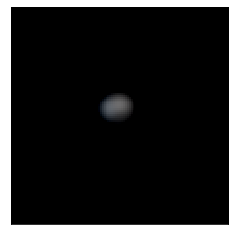

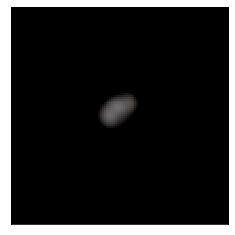

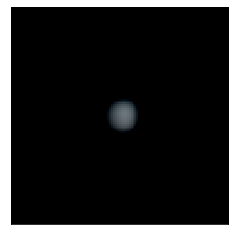

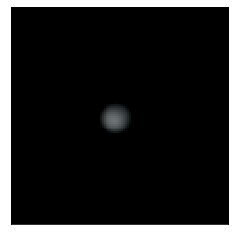

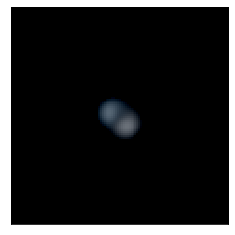

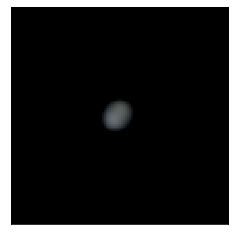

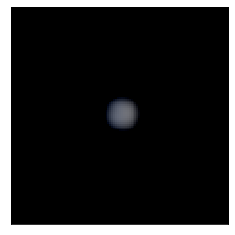

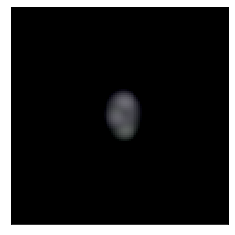

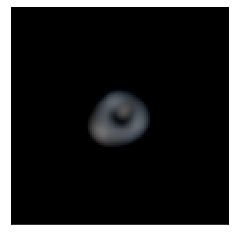

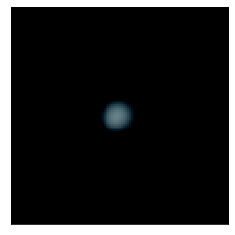

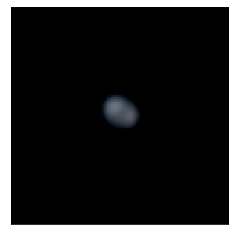

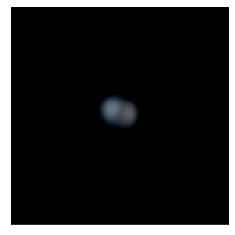

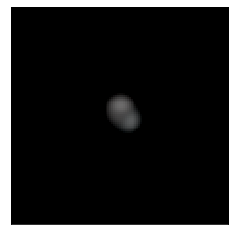

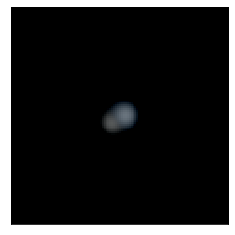

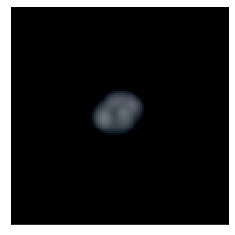

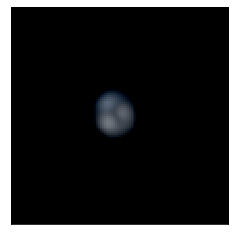

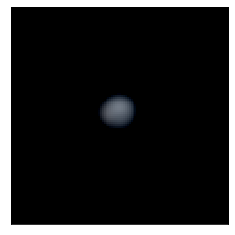

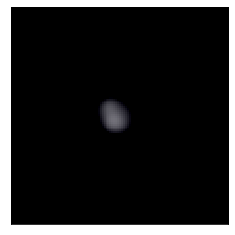

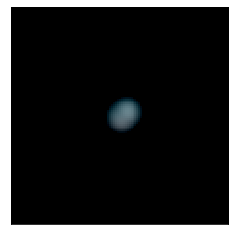

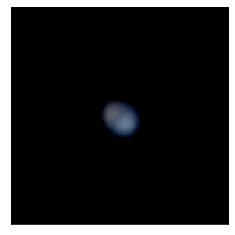

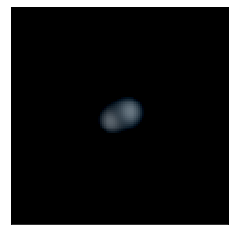

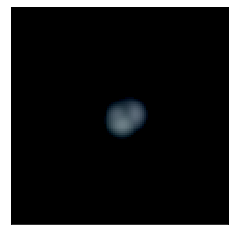

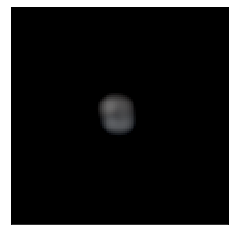

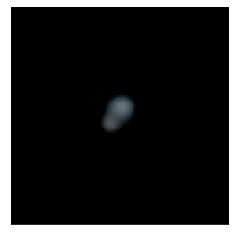

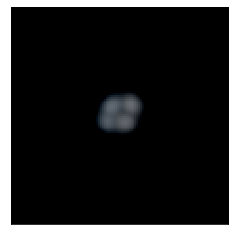

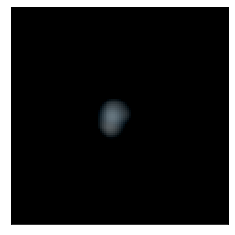

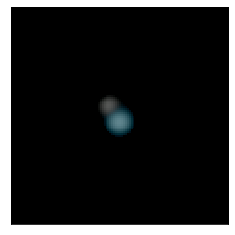

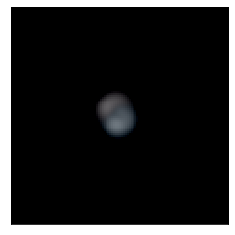

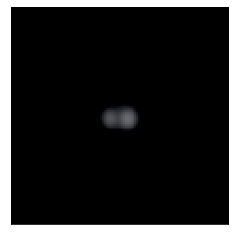

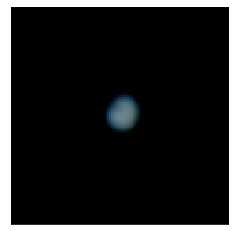

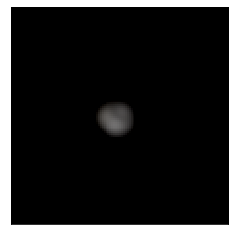

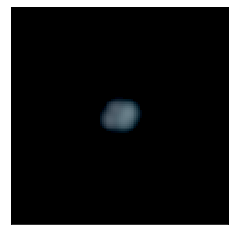

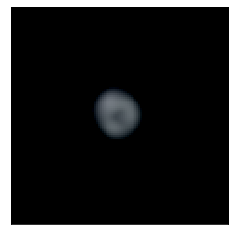

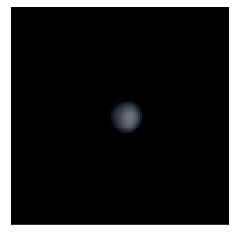

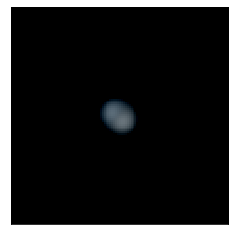

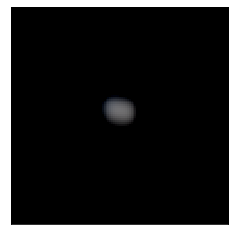

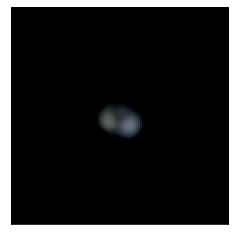

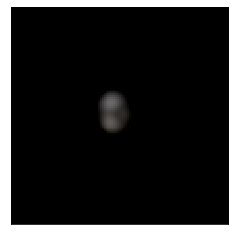

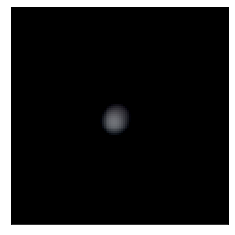

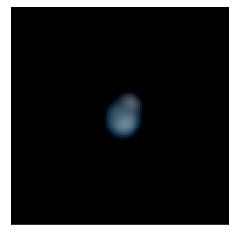

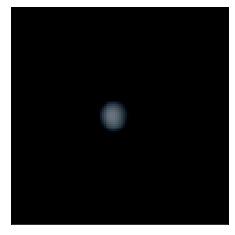

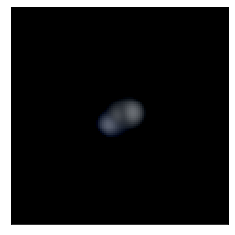

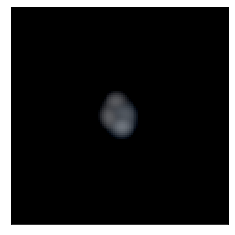

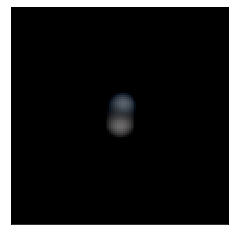

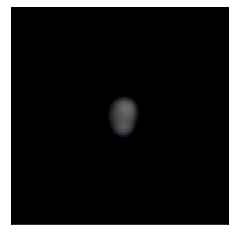

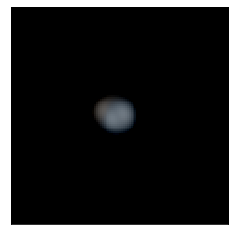

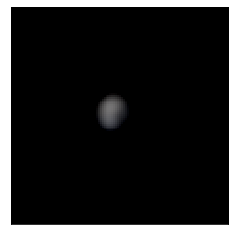

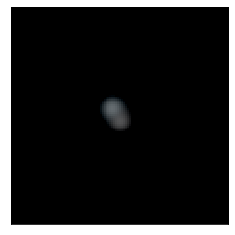

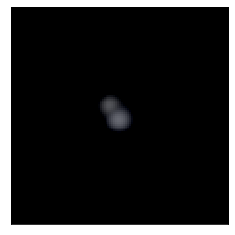

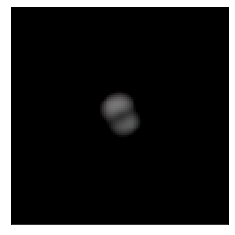

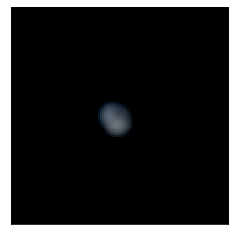

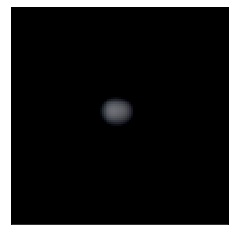

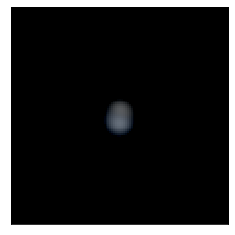

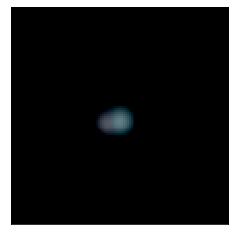

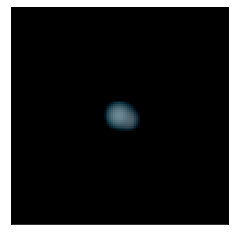

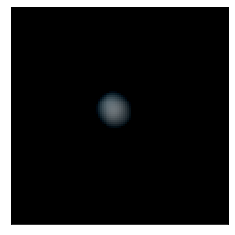

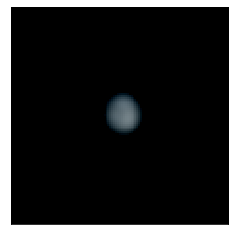

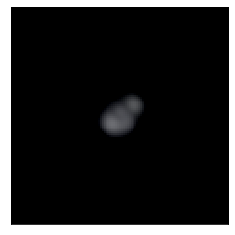

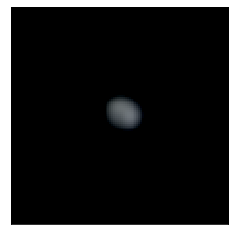

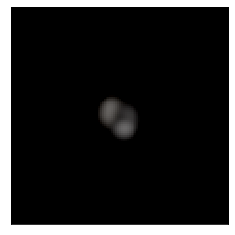

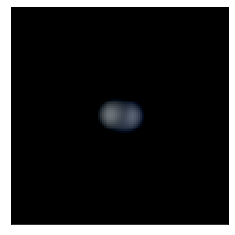

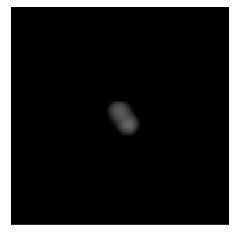

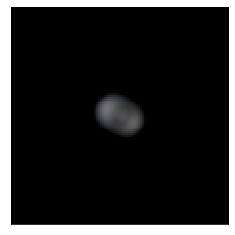

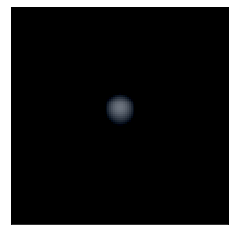

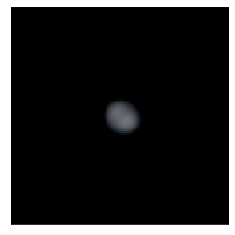

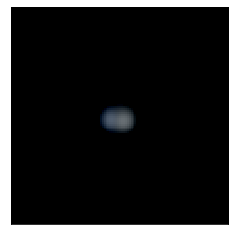

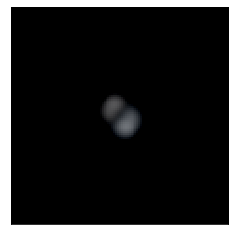

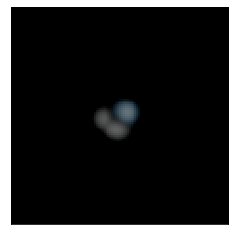

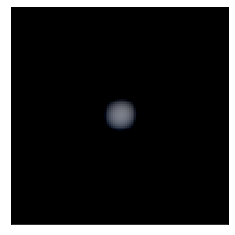

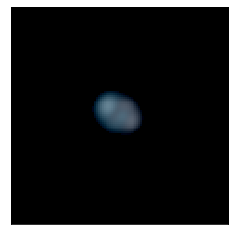

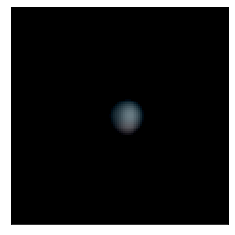

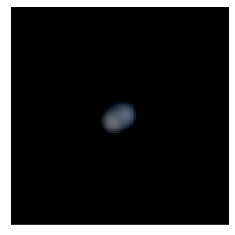

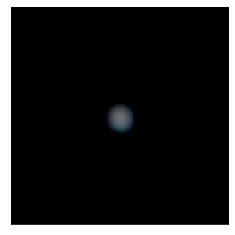

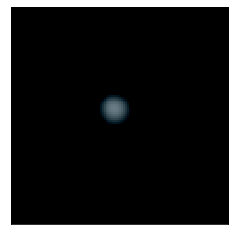

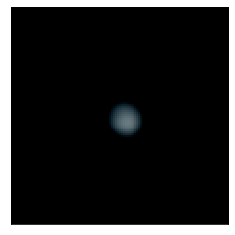

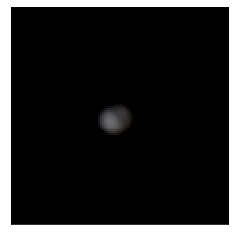

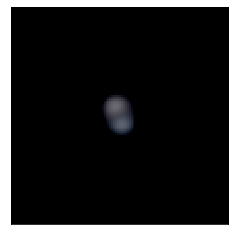

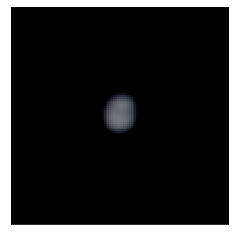

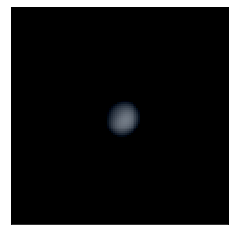

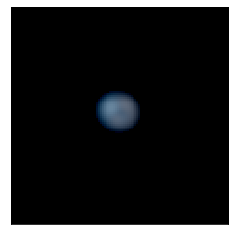

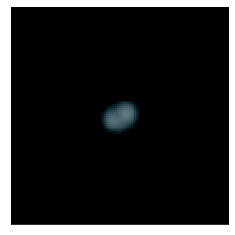

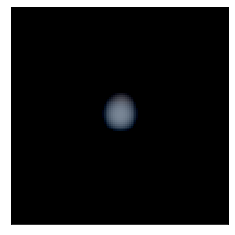

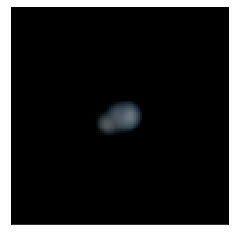

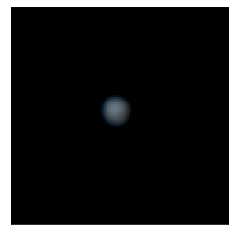

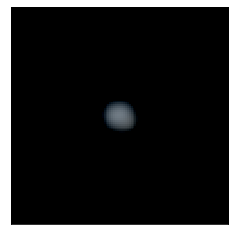

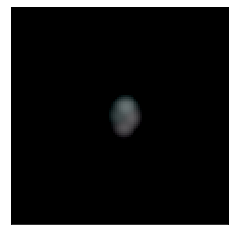

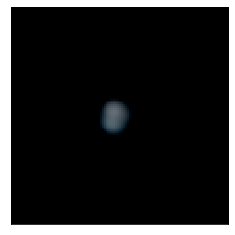

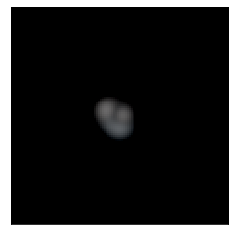

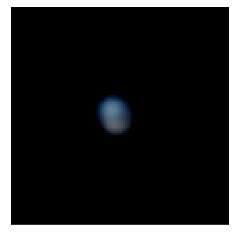

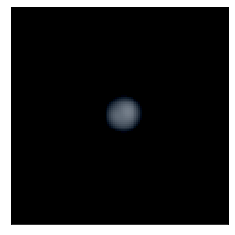

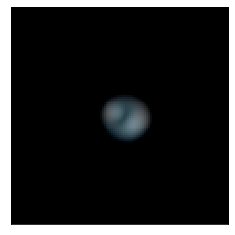

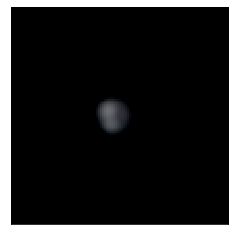

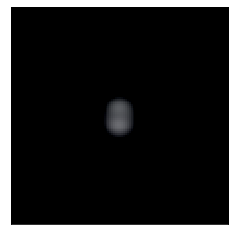

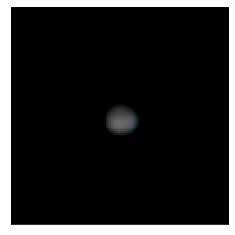

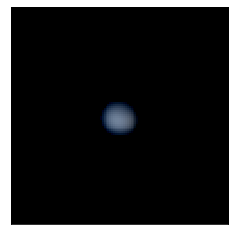

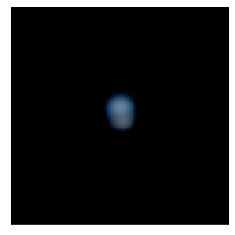

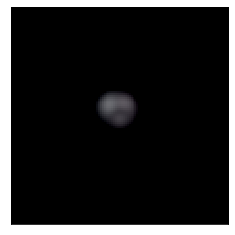

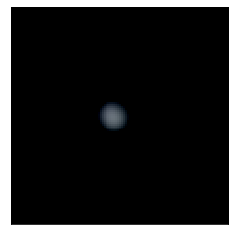

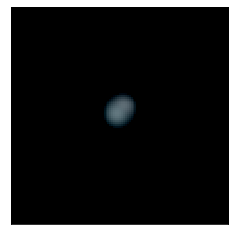

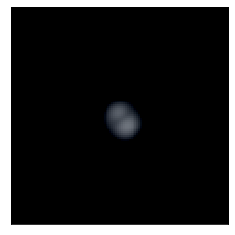

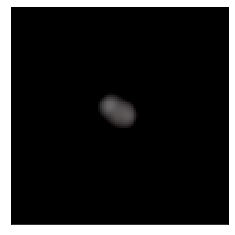

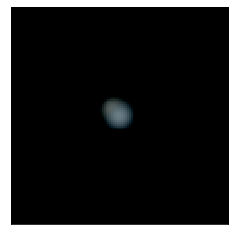

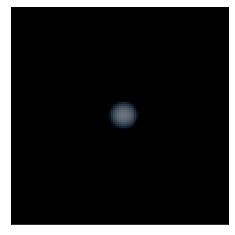

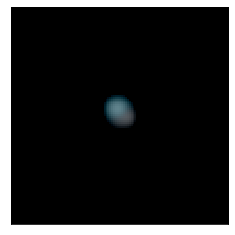

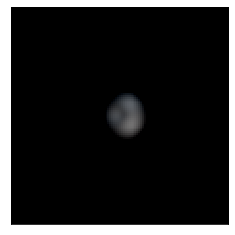

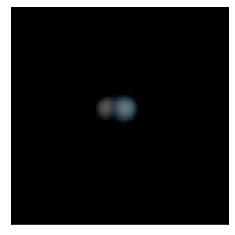

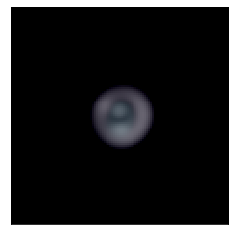

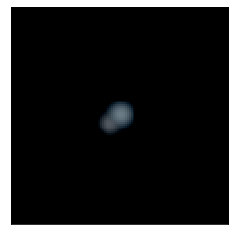

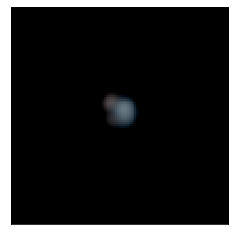

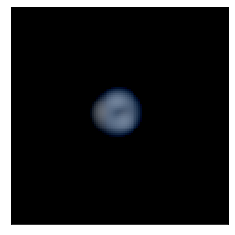

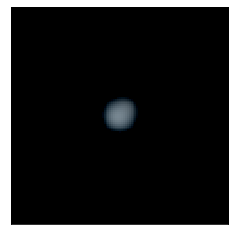

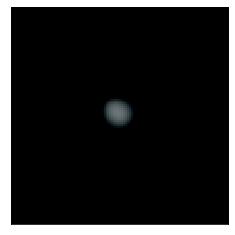

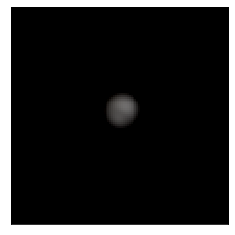

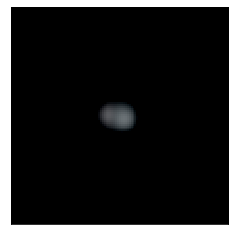

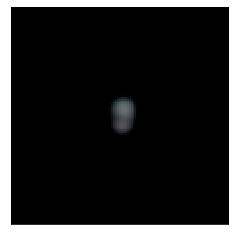

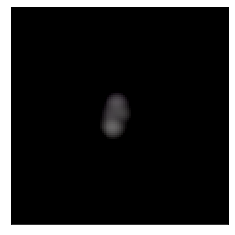

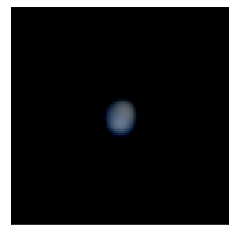

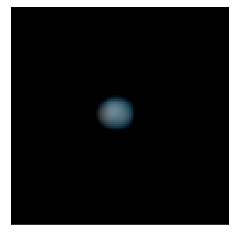

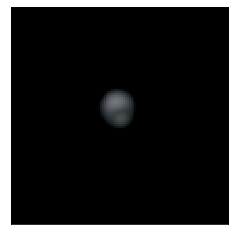

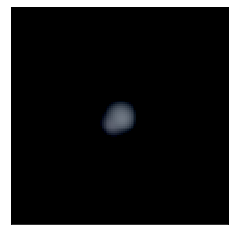

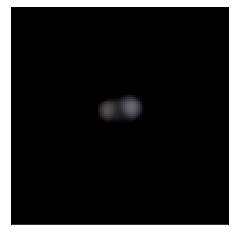

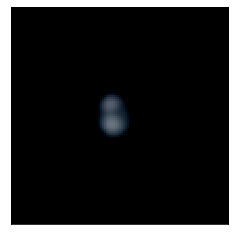

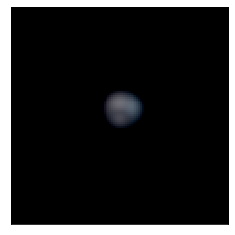

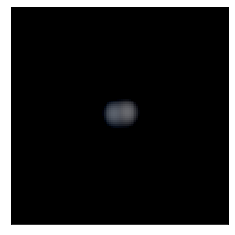

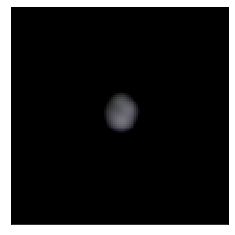

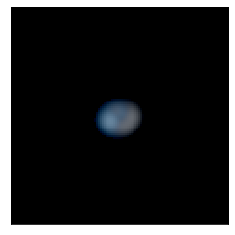

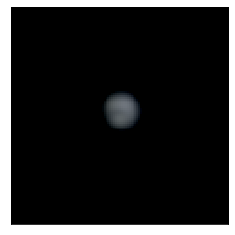

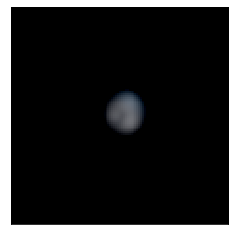

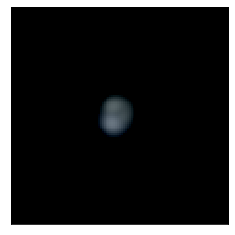

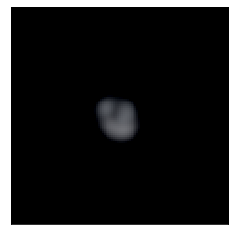

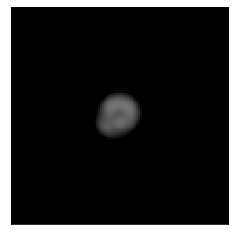

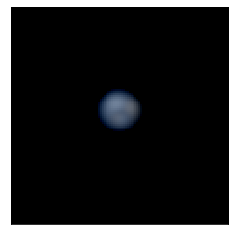

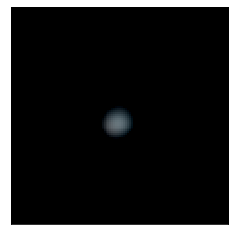

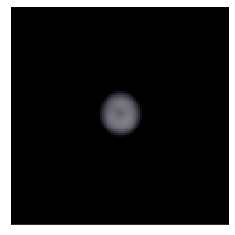

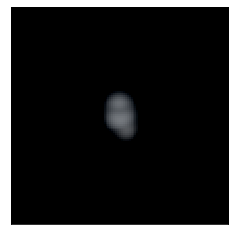

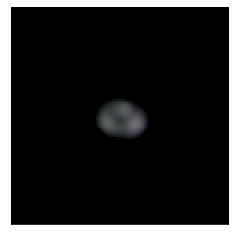

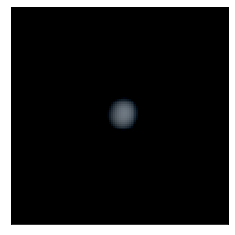

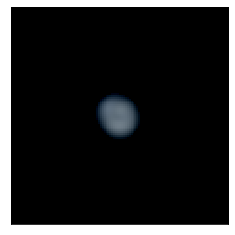

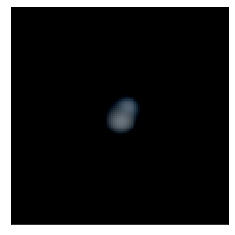

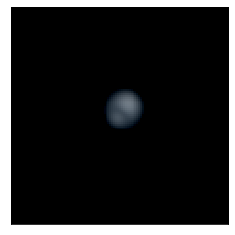

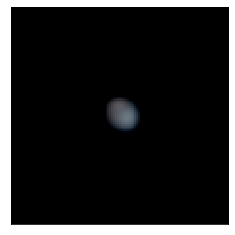

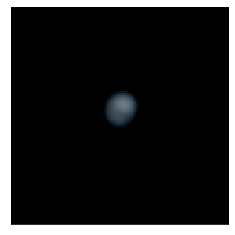

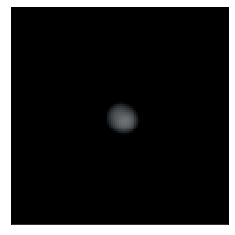

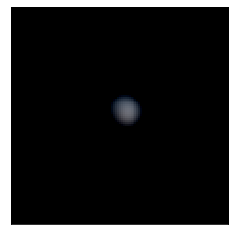

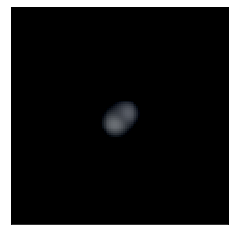

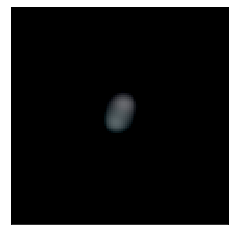

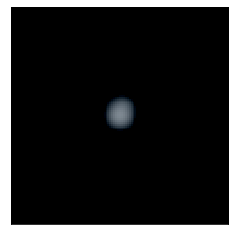

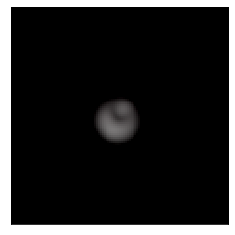

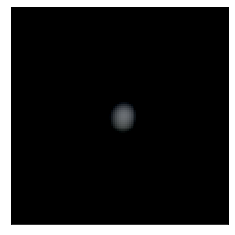

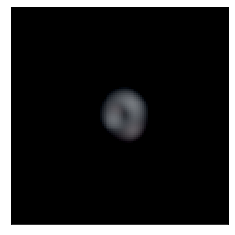

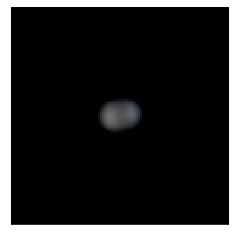

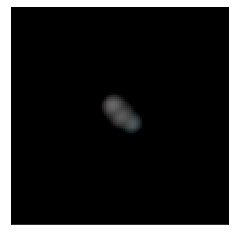

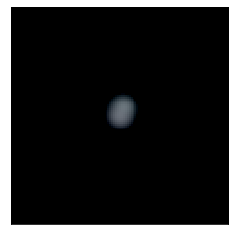

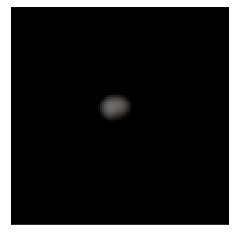

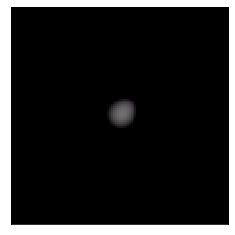

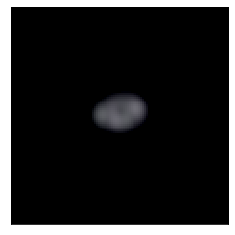

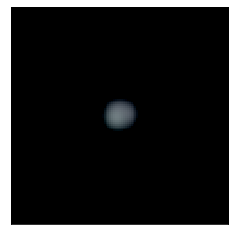

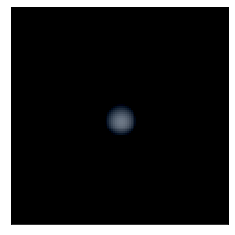

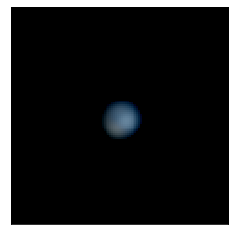

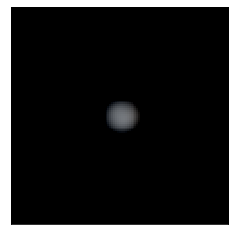

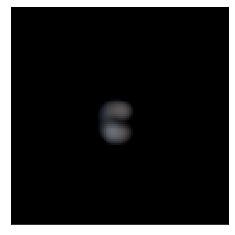

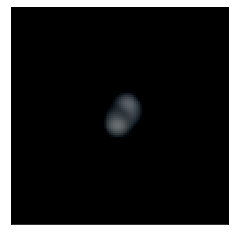

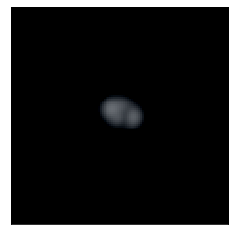

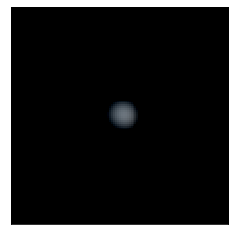

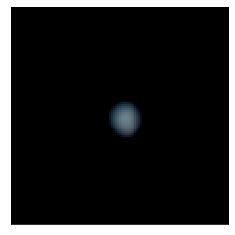

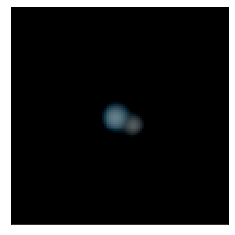

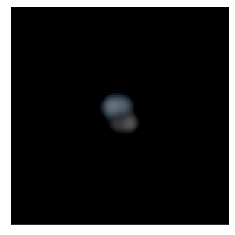

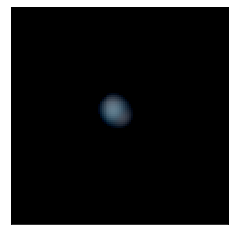

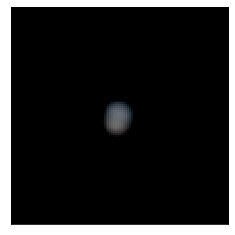

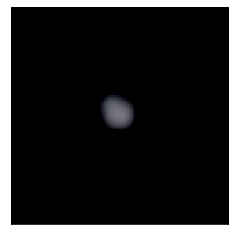

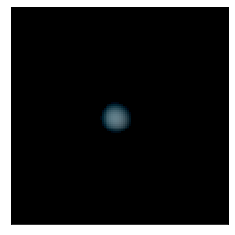

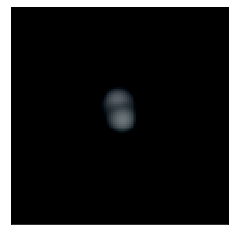

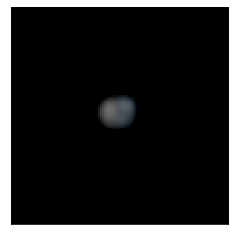

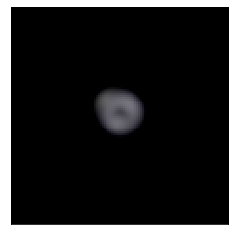

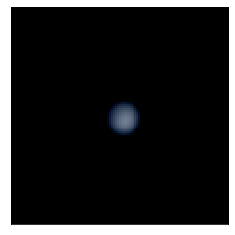

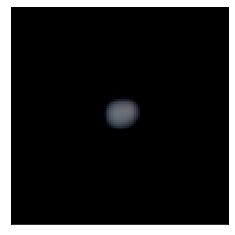

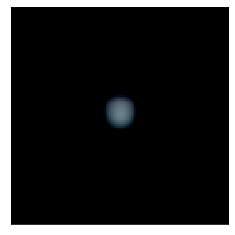

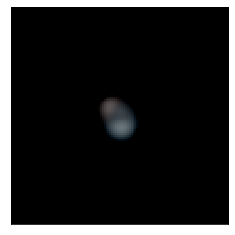

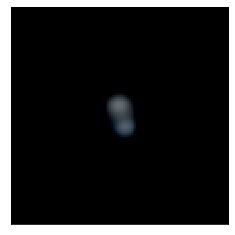

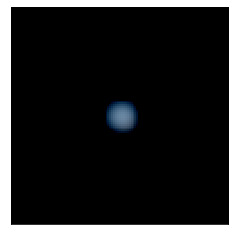

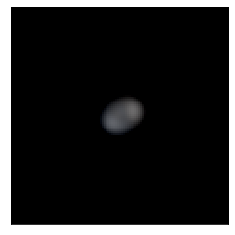

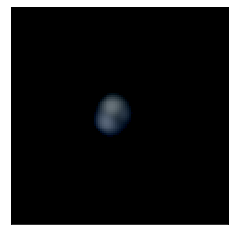

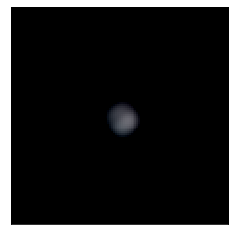

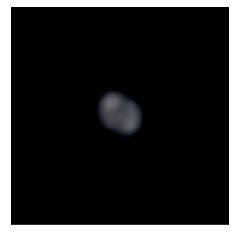

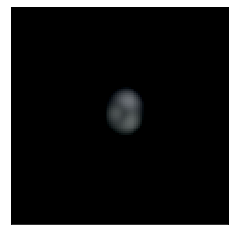

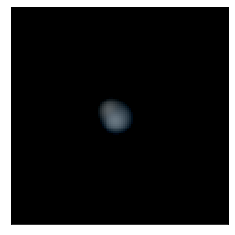

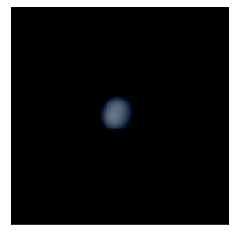

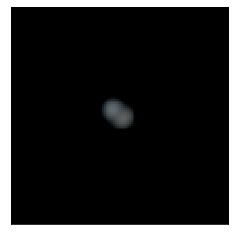

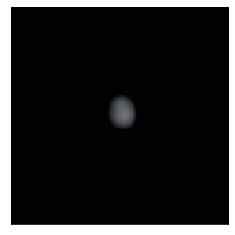

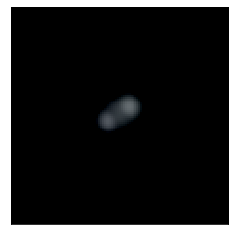

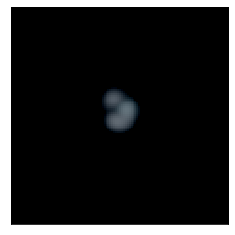

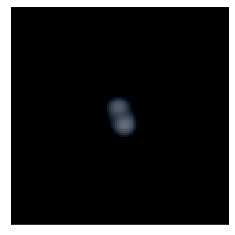

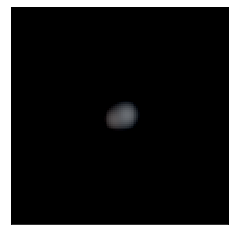

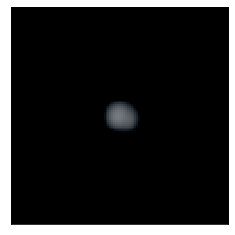

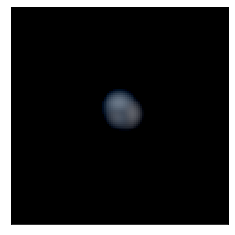

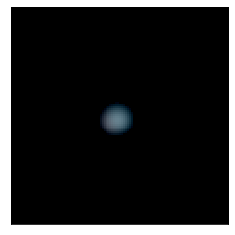

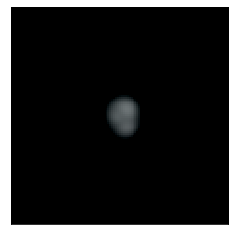

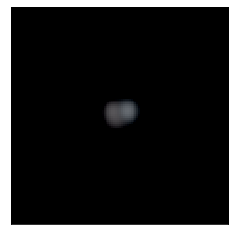

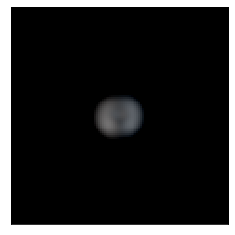

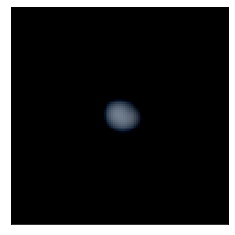

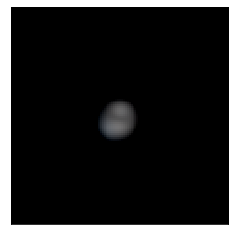

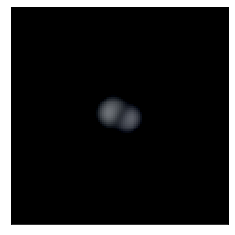

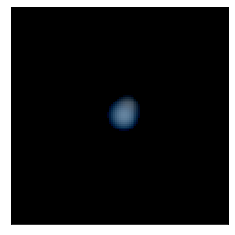

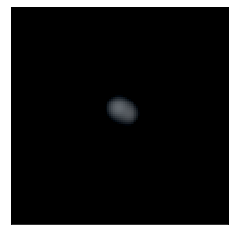

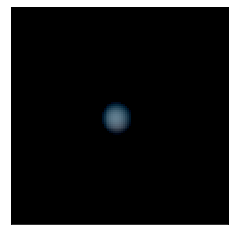

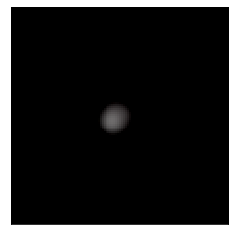

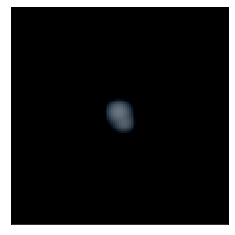

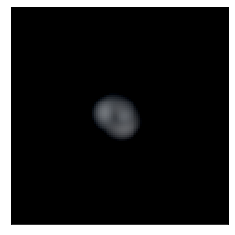

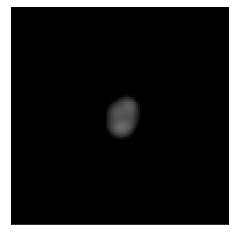

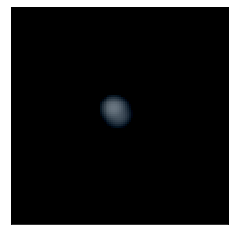

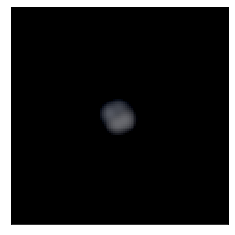

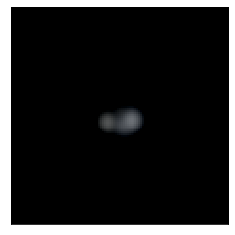

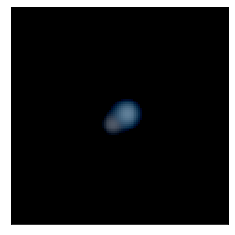

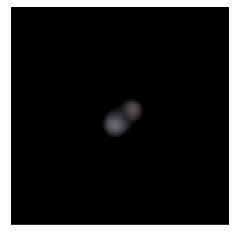

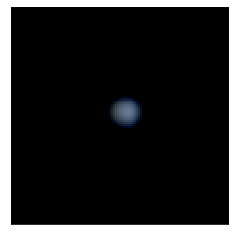

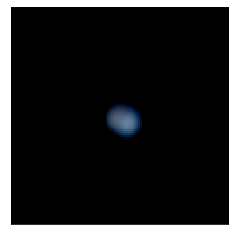

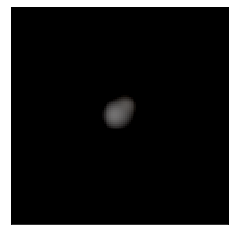

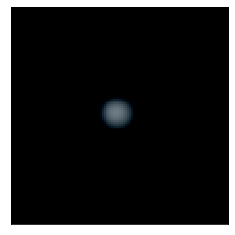

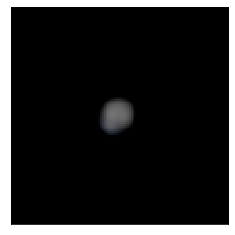

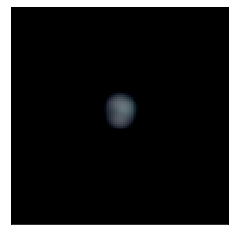

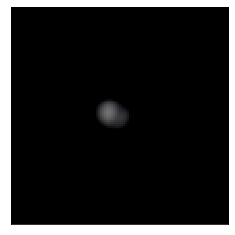

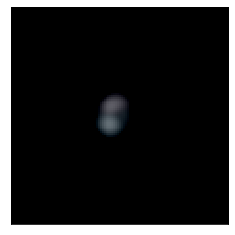

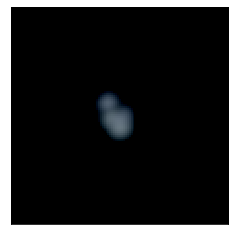

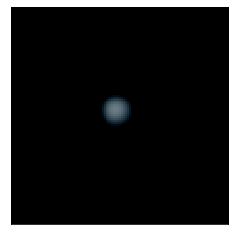

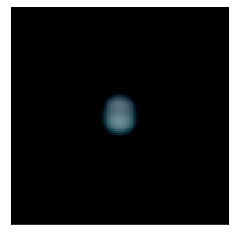

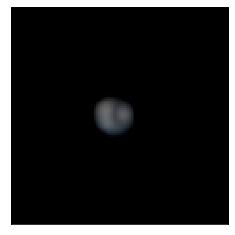

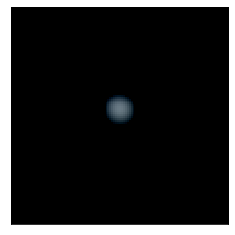

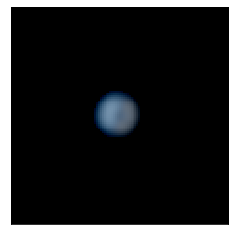

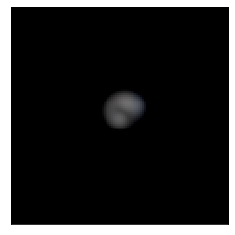

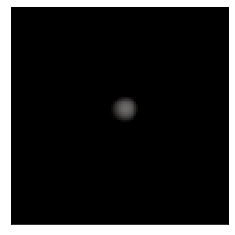

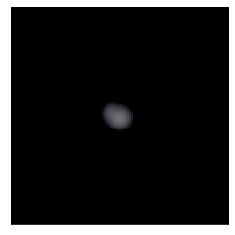

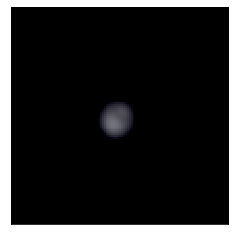

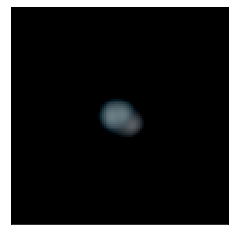

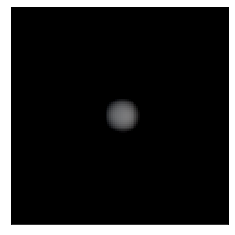

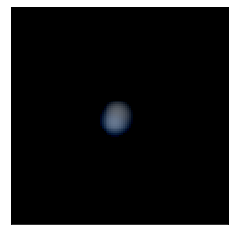

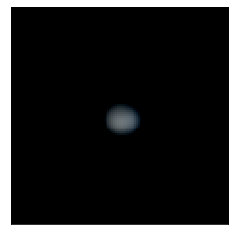

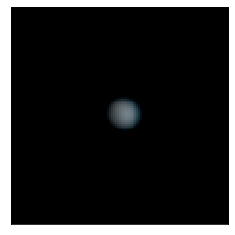

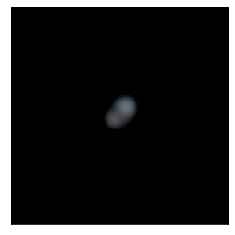

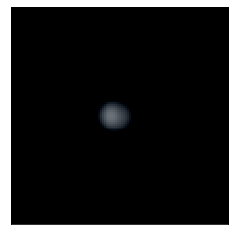

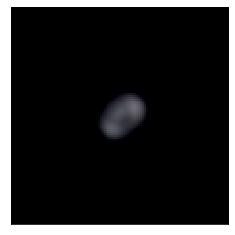

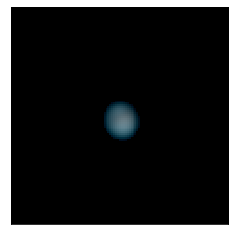

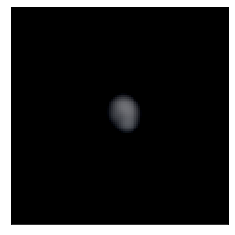

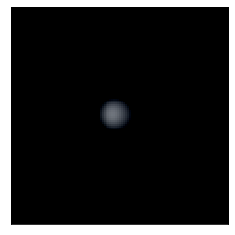

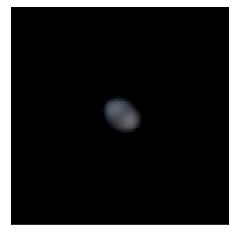

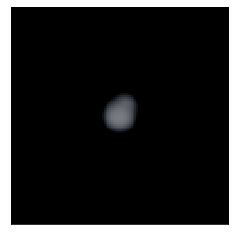

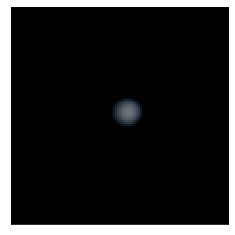

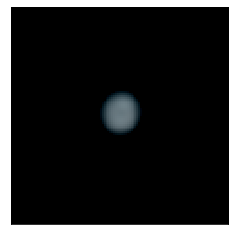

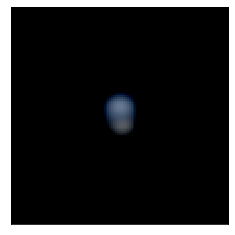

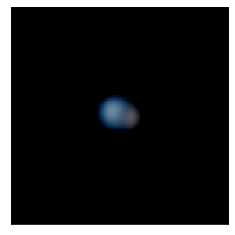

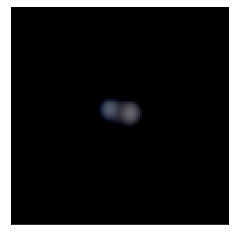

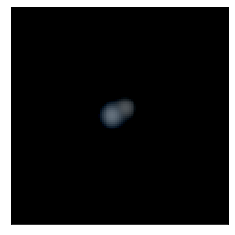

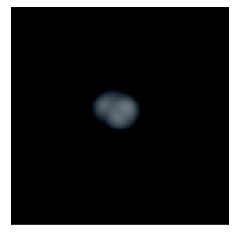

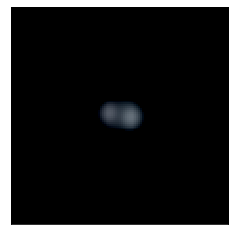

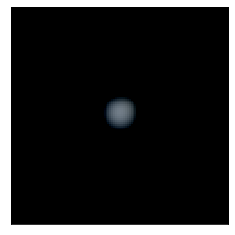

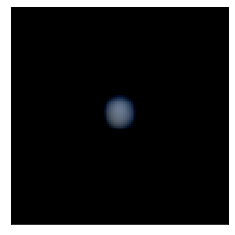

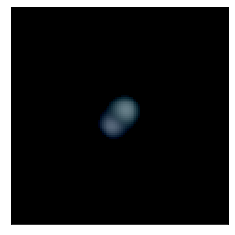

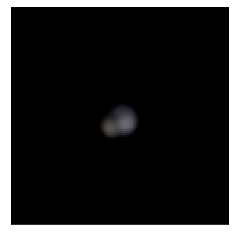

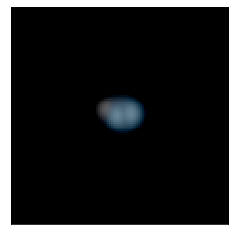

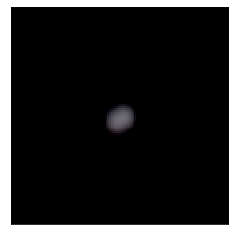

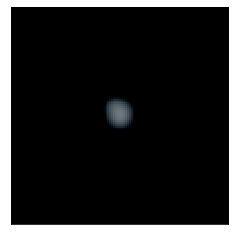

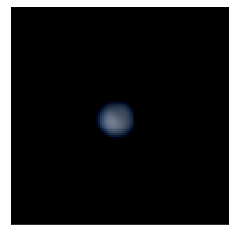

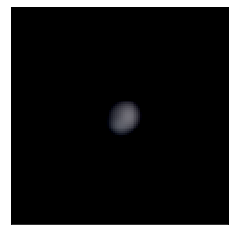

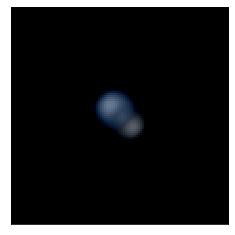

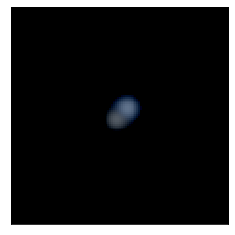

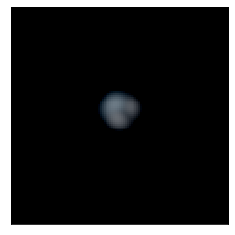

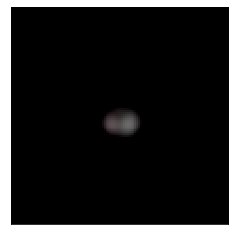

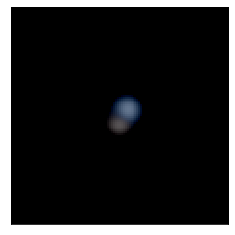

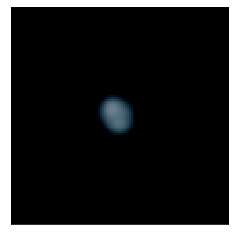

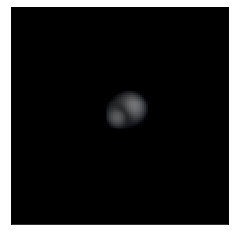

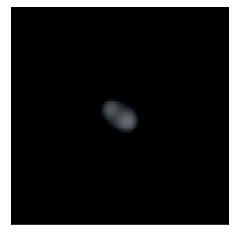

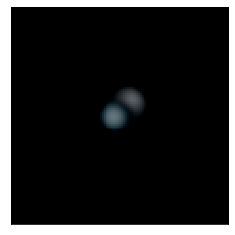

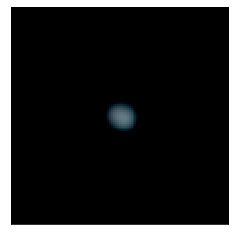

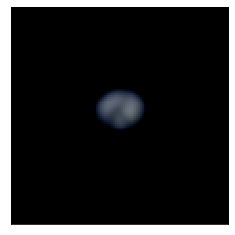

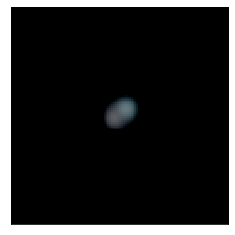

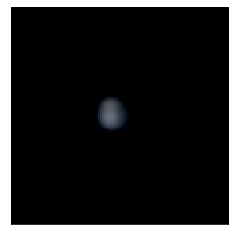

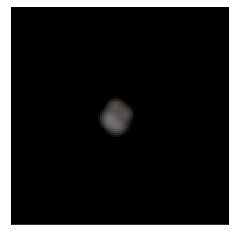

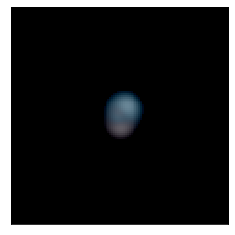

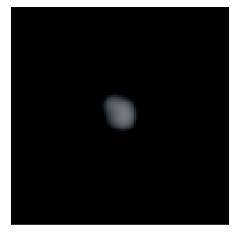

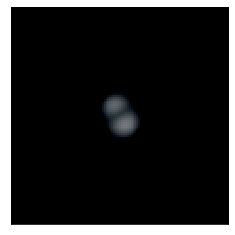

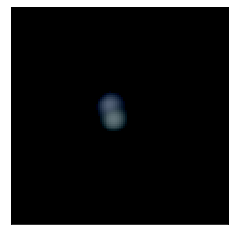

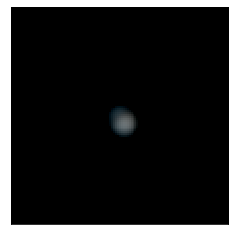

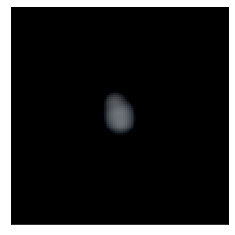

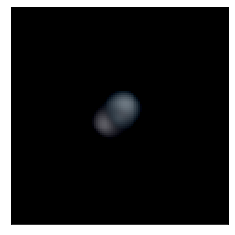

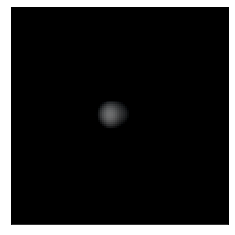

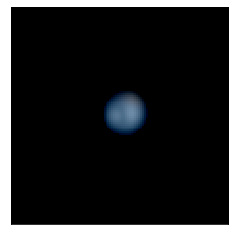

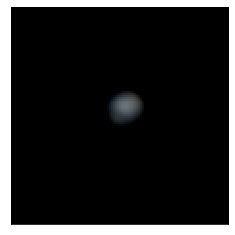

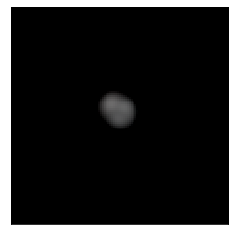

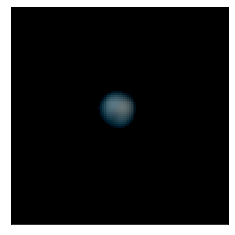

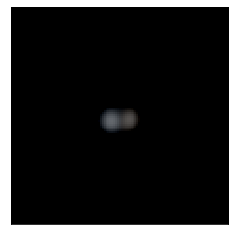

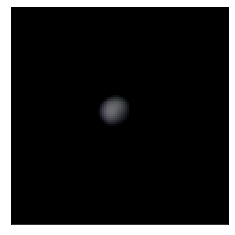

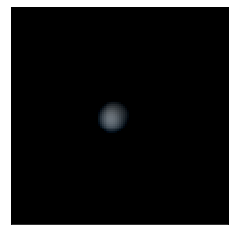

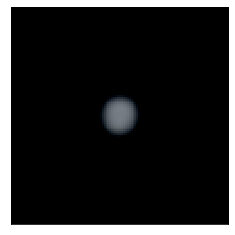

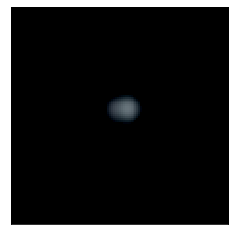

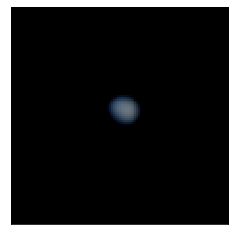

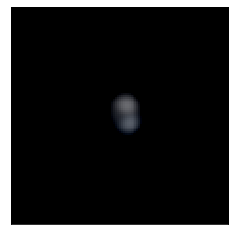

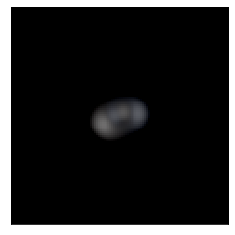

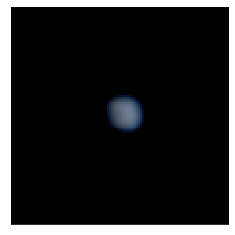

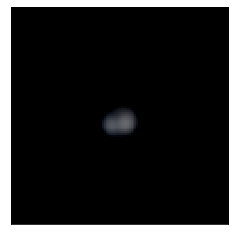

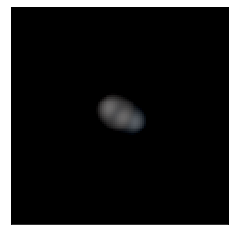

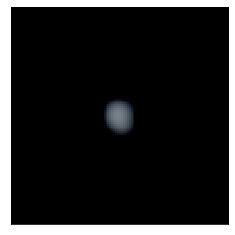

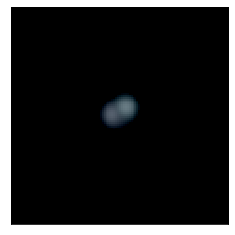

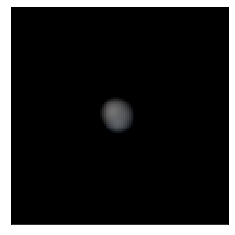

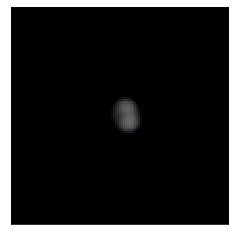

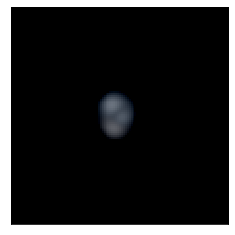

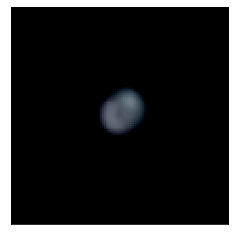

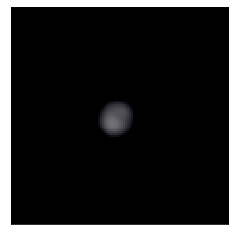

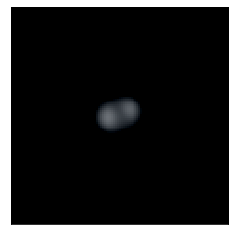

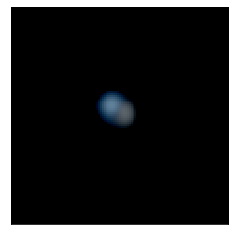

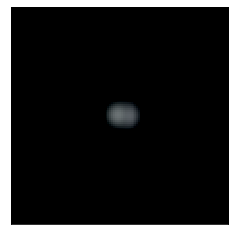

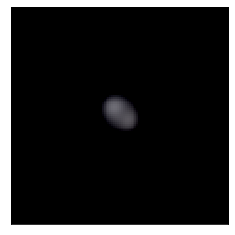

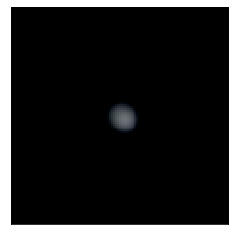

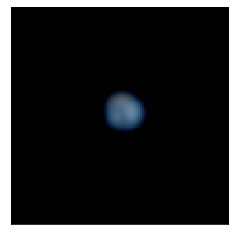

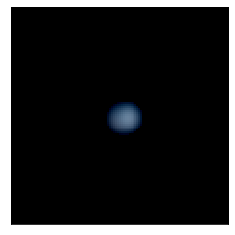

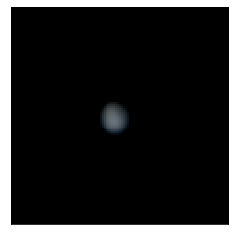

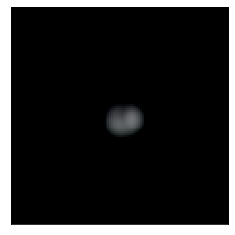

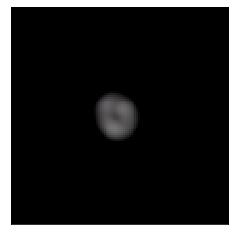

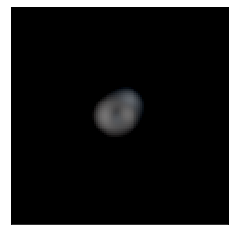

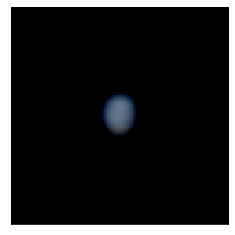

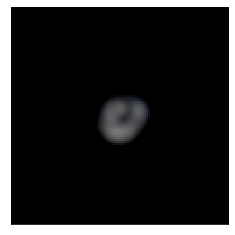

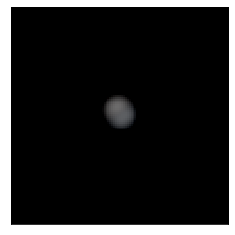

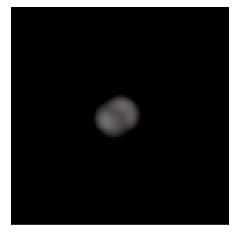

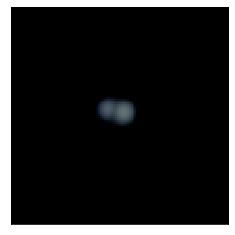

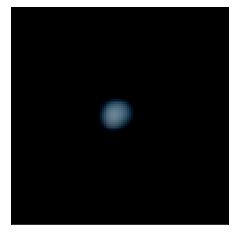

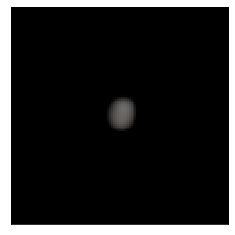

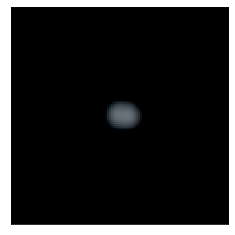

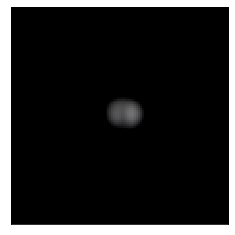

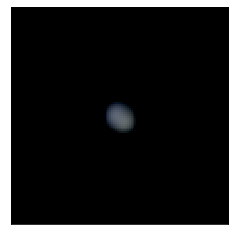

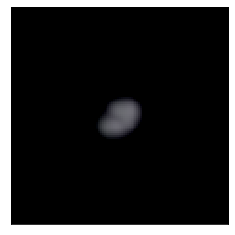

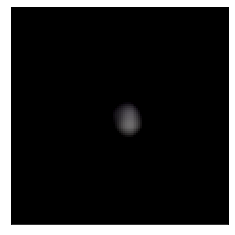

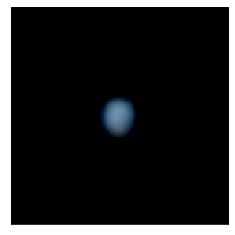

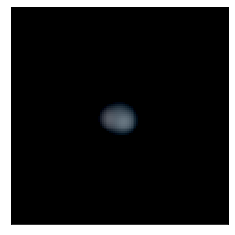

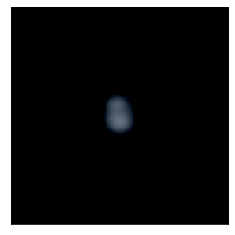

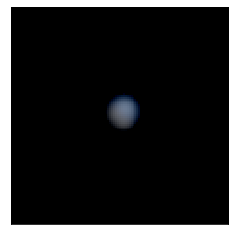

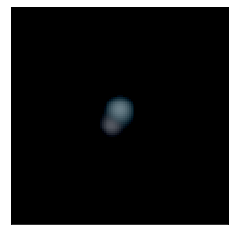

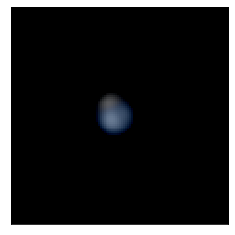

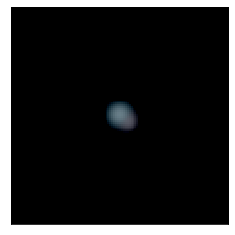

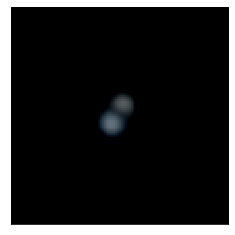

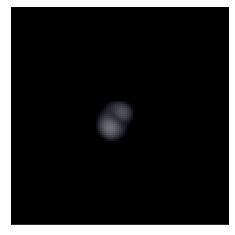

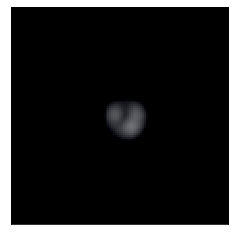

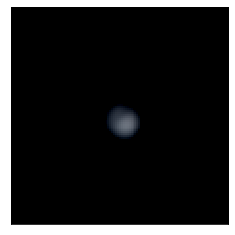

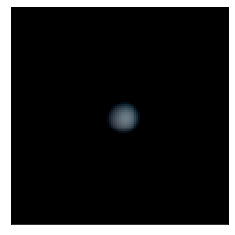

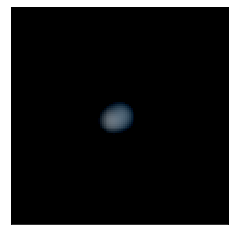

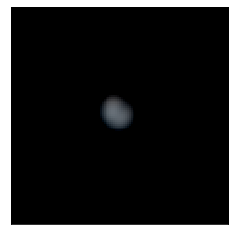

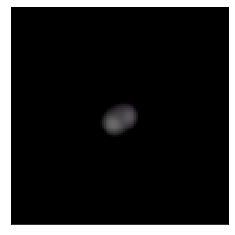

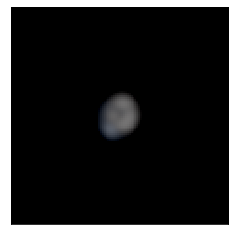

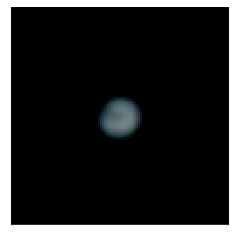

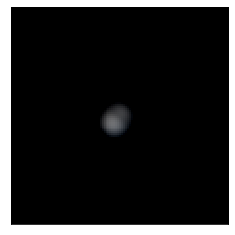

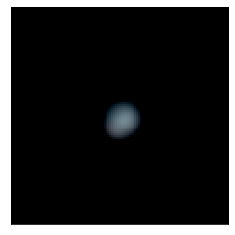

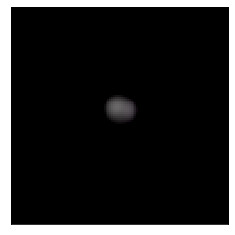

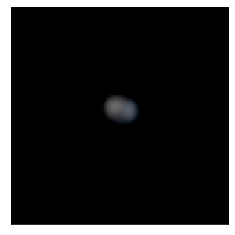

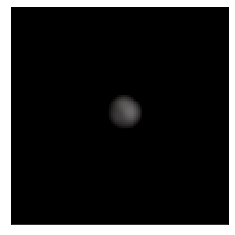

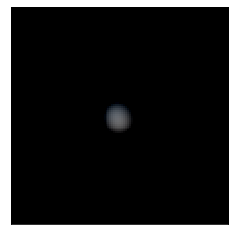

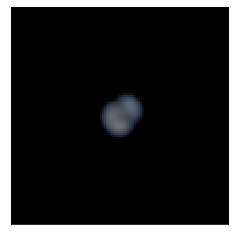

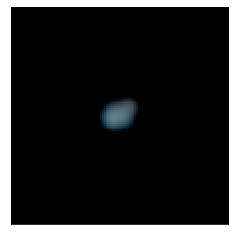

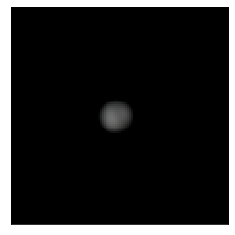

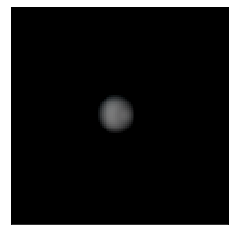

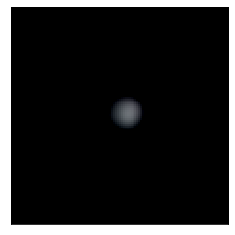

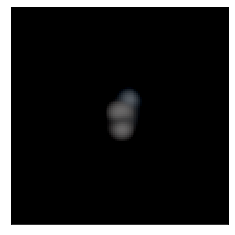

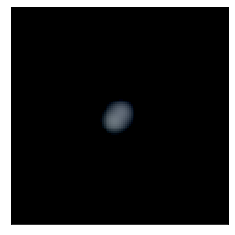

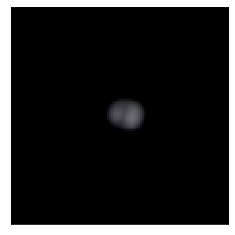

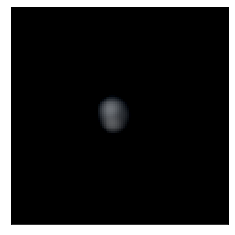

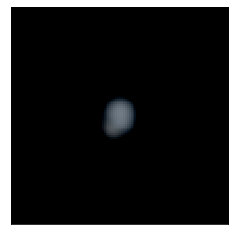

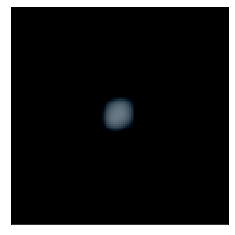

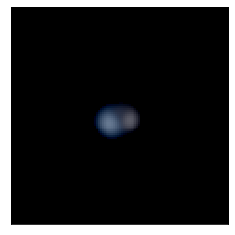

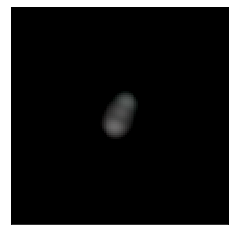

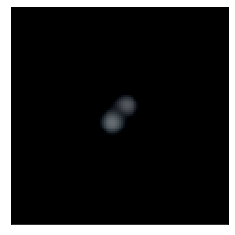

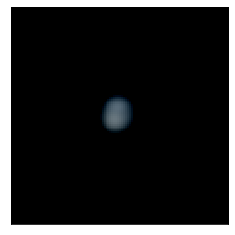

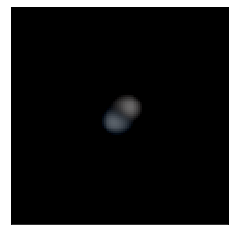

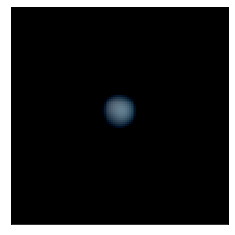

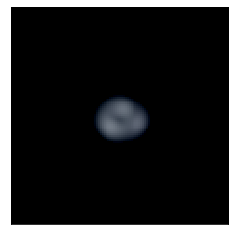

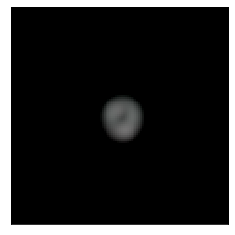

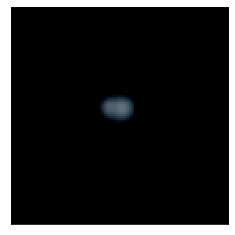

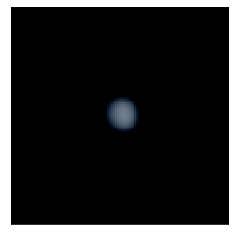

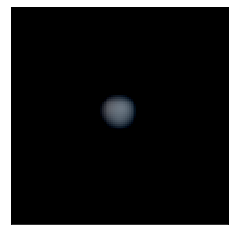

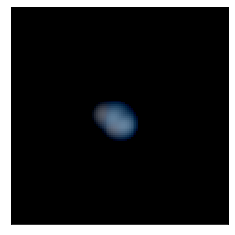

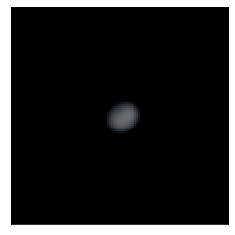

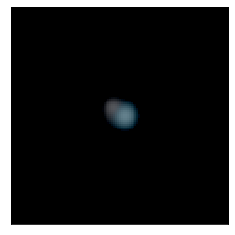

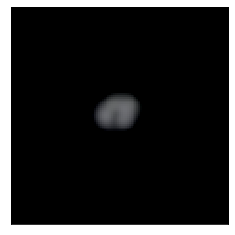

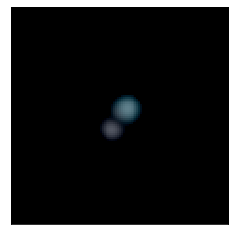

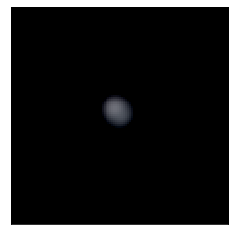

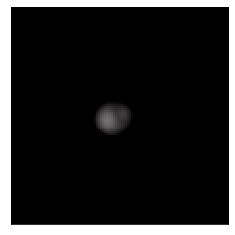

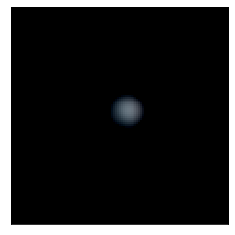

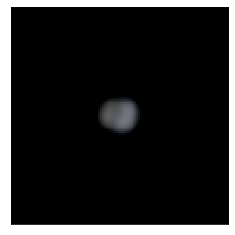

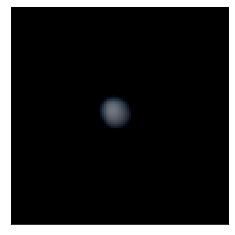

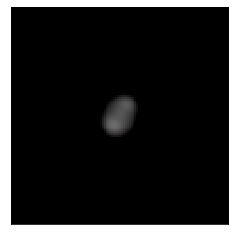

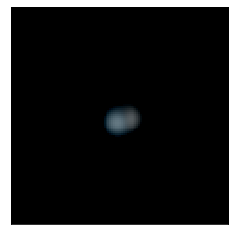

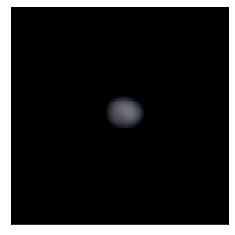

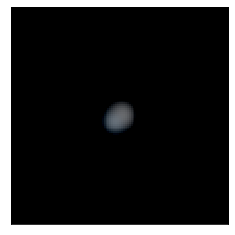

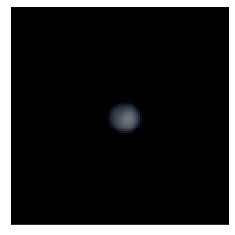

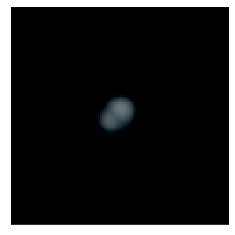

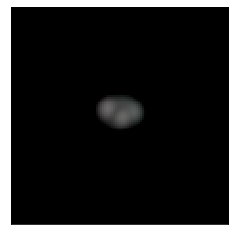

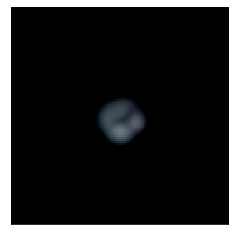

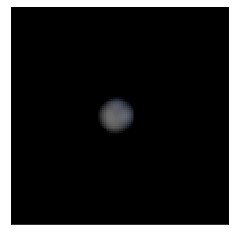

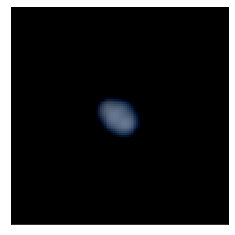

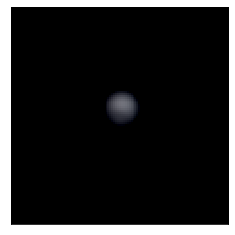

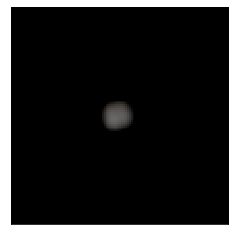

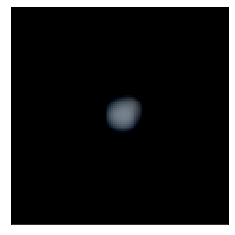

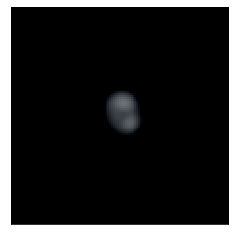

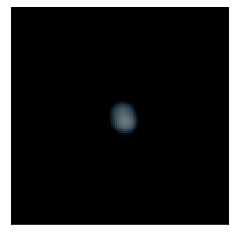

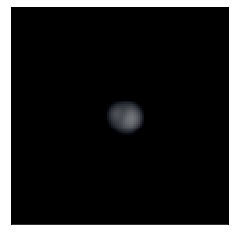

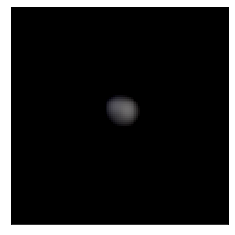

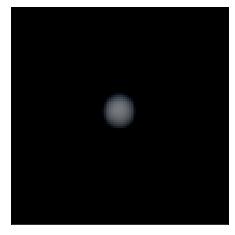

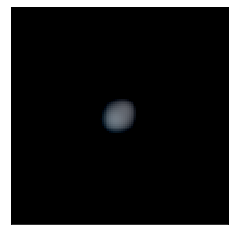

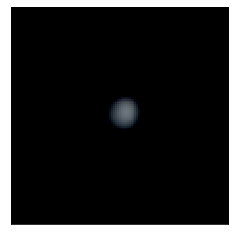

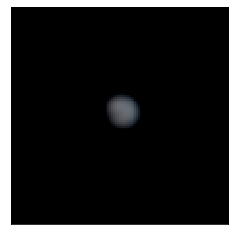

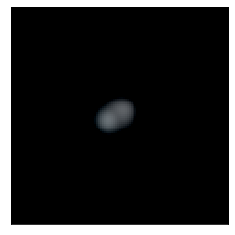

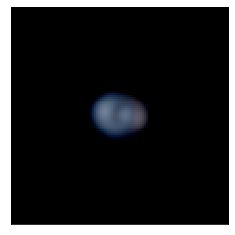

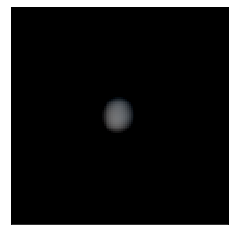

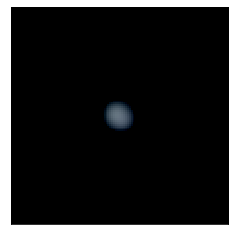

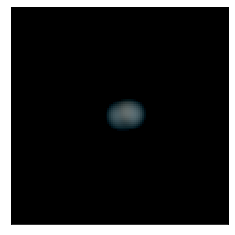

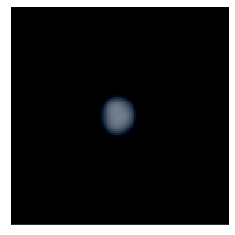

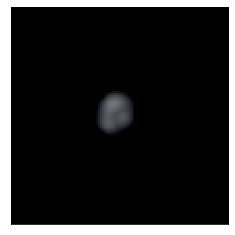

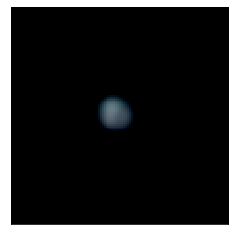

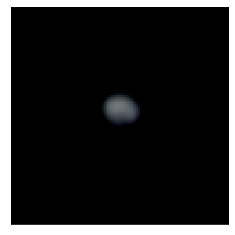

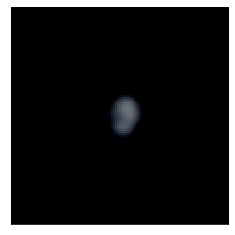

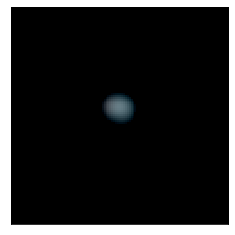

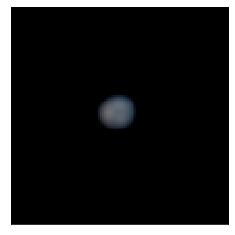

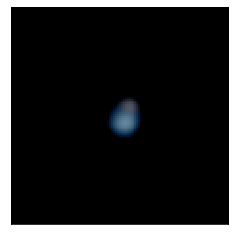

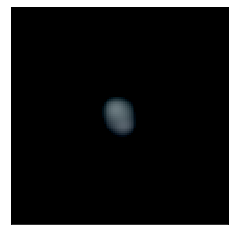

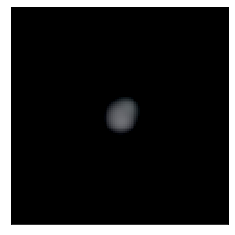

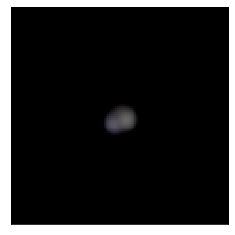

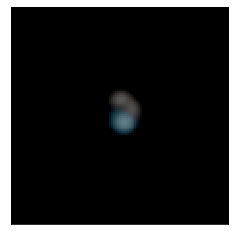

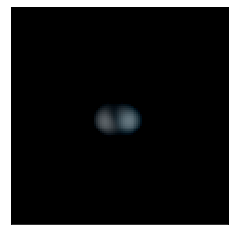

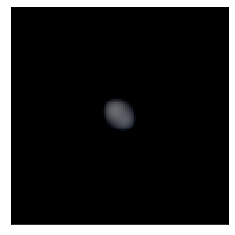

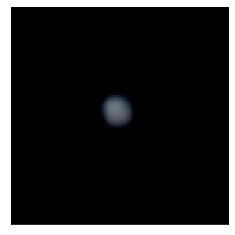

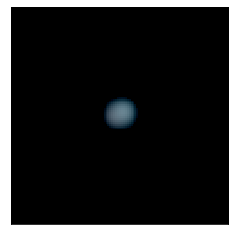

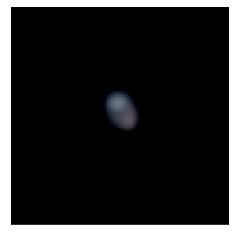

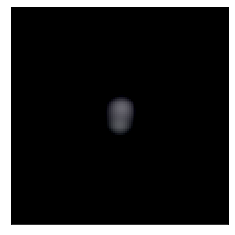

In [6]:
for index, row in data.iterrows():
    if index == 800:
        break
    zlens = row['Z']
    zsource1 = random.uniform(zlens, 1.2)
    zsource2 = random.uniform(zsource1, 1.3)
    dispersion = row['VEL_DISP']
    center_lens = [0, 0]
    center_source1 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    center_source2 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    
    angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
    angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
    ratio = random.uniform(0.001, 1) #distribution for the axis ratio
    e1, e2 = param.phi_q2_ellipticity(angle, ratio)
    lens_ellip = [e1, e2]
    
    funcion(zlens, zsource1, zsource2, dispersion, center_lens, center_source1, center_source2, lens_ellip, index)

In [7]:
! convert -delay 50 -loop 0 *.png Only_sources_data.gif
! rm *.png